In [ ]:
# CIFAR0-10 learning to reject.ipynb

# Text cell <undefined>
# #%% [markdown]
# This notebook goes through learning a classifier and rejector using our proposed loss function L_{CE}^{\alpha} for a synthehtic expert (described in the paper) on CIFAR-10/100.

# Text cell <a7Aympk-qwGu>
# #%% [markdown]
# # Preliminaries: model definition and utilities
# !git clone https://github.com/clinicalml/learn-to-defer.git
# !rm -r conformal_classification
# !git clone https://github.com/aangelopoulos/conformal_classification.git
# Code cell <cFhWBUzvqmZF>
# %% [code]
import math
import torch
import torch.nn as nn
import random
import numpy as np
import torch.nn.functional as F
import argparse
import os
import shutil
import time
import torch.nn.parallel
import torchvision
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import pickle as pkl
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import os, sys, inspect
sys.path.insert(1, os.path.join(sys.path[0], './conformal_classification/'))
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


# Text cell <plcXrgr8q_dR>
# #%% [markdown]
# WideResNet from following [repo](https://github.com/xternalz/WideResNet-pytorch/blob/master/wideresnet.py)

# Code cell <qP2NJY4BrEH8>
# %% [code]
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                                                                padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)


class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
        assert ((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]
        self.softmax = nn.Softmax()
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        out = self.fc(out)
        # out = self.softmax(out)
        return out

# Text cell <9ll6QD_IrQeD>
# #%% [markdown]
# metrics and utilities

# Code cell <m93DvFTXrRwt>
# #%% [code]
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def metrics_print(net,expert_fn, n_classes, loader,return_stats = False):
    '''
    Computes metrics for deferal
    -----
    Arguments:
    net: model
    expert_fn: expert model
    n_classes: number of classes
    loader: data loader
    '''
    correct = 0
    correct_sys = 0
    exp = 0
    exp_total = 0
    total = 0
    real_total = 0
    alone_correct = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            outputs = nn.Softmax()(outputs)
            _, predicted = torch.max(outputs.data, 1)
            batch_size = outputs.size()[0]  # batch_size
            exp_prediction = expert_fn(images, labels)
            for i in range(0, batch_size):
                r = (predicted[i].item() == n_classes)
                prediction = predicted[i]
                if predicted[i] == n_classes:
                    max_idx = 0
                    # get second max
                    for j in range(0, n_classes):
                        if outputs.data[i][j] >= outputs.data[i][max_idx]:
                            max_idx = j
                    prediction = max_idx
                else:
                    prediction = predicted[i]
                alone_correct += (prediction == labels[i]).item()
                if r == 0:
                    total += 1
                    correct += (predicted[i] == labels[i]).item()
                    correct_sys += (predicted[i] == labels[i]).item()
                if r == 1:
                    exp += (exp_prediction[i] == labels[i].item())
                    correct_sys += (exp_prediction[i] == labels[i].item())
                    exp_total += 1
                real_total += 1
    cov = str(total) + str(" out of") + str(real_total)
    to_print = {"coverage": cov, "system accuracy": 100 * correct_sys / real_total,
                "expert accuracy": 100 * exp / (exp_total + 0.0002),
                "classifier accuracy": 100 * correct / (total + 0.0001),
                "alone classifier": 100 * alone_correct / real_total}
    print(to_print)
    if return_stats:
      return correct_sys / real_total


def metrics_print_baseline(net_class, expert_fn, n_classes, loader):
    correct = 0
    correct_sys = 0
    exp = 0
    exp_total = 0
    total = 0
    real_total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs_class = net_class(images)
            outputs_class = nn.Softmax()(outputs_class)
            _, predicted = torch.max(outputs_class.data, 1)
            batch_size = outputs_class.size()[0]  # batch_size

            exp_prediction = expert_fn(images, labels)
            for i in range(0, batch_size):
                r = (exp_prediction[i] == labels[i].item())
                if r == 0:
                    total += 1
                    prediction = predicted[i]
                    if predicted[i] == n_classes:
                        max_idx = 0
                        for j in range(0, n_classes):
                            if outputs_class.data[i][j] >= outputs_class.data[i][max_idx]:
                                max_idx = j
                        prediction = max_idx
                    else:
                        prediction = predicted[i]
                    correct += (prediction == labels[i]).item()
                    correct_sys += (prediction == labels[i]).item()
                if r == 1:
                    exp += (exp_prediction[i] == labels[i].item())
                    correct_sys += (exp_prediction[i] == labels[i].item())
                    exp_total += 1
                real_total += 1
    cov = str(total) + str(" out of") + str(real_total)
    to_print = {"coverage": cov, "system accuracy": 100 * correct_sys / real_total,
                "expert accuracy": 100 * exp / (exp_total + 0.0002),
                "classifier accuracy": 100 * correct / (total + 0.0001)}
    print(to_print)


# Text cell <E-GzRg6nrsSB>
# #%% [markdown]
# # Our Method

# Code cell <4bojqcOrsdDA>
# #%% [code]
def reject_CrossEntropyLoss(outputs, m, labels, m2, n_classes):
    '''
    The L_{CE} loss implementation for CIFAR
    ----
    outputs: network outputs
    m: cost of deferring to expert cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
    labels: target
    m2:  cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
    n_classes: number of classes
    '''
    batch_size = outputs.size()[0]  # batch_size
    rc = [n_classes] * batch_size # This is the expert class (class 100) so when m = 1 we defer to the expert
    # print(torch.log2(outputs[range(batch_size), rc]),outputs)
    outputs = -m * torch.log2(outputs[range(batch_size), rc]) - m2 * torch.log2(
        outputs[range(batch_size), labels])
    return torch.sum(outputs) / batch_size

# def defer_CrossEntropyLoss(outputs, m, labels, m2, n_classes):
#     '''
#     The L_{CE} loss implementation for CIFAR
#     ----
#     outputs: network outputs
#     m: cost of deferring to expert cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
#     labels: target
#     m2:  cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
#     n_classes: number of classes
#     '''
#     batch_size = outputs.size()[0]  # batch_size
#     rc = [n_classes] * batch_size # This is the expert class (class 100) so when m = 1 we defer to the expert
#     outputs = -m * torch.log2(outputs[range(batch_size), rc])
#     # outputs = -0.2*m * torch.log2(outputs[range(batch_size), rc]) - m2 * torch.log(outputs[range(batch_size), labels]) + skewloss(m,outputs,labels)  
#     return torch.sum(outputs) / batch_size

def my_CrossEntropyLoss(outputs, labels,skew=False,skewloss=None,n_epoch=0):
    # Regular Cross entropy loss
    if not skew:
      batch_size = outputs.size()[0]  # batch_size
      outputs = - torch.log2(outputs[range(batch_size), labels]) # regular CE
      return torch.sum(outputs) / batch_size
    else:
      return skewloss(outputs,labels,flag=False,n_epoch=n_epoch)    

def train_reject(train_loader, model, optimizer, scheduler, epoch, expert_fn, n_classes, alpha,beta=1):
    """Train for one epoch on the training set with deferral"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        target = target.to(device)
        input = input.to(device)
        # compute output
        output = model(input)
        output = nn.Softmax()(output)
        # _,idxs = torch.sort(output[:,-1],descending=True)
        # output = output[idxs]
        # target = target[idxs]
        # input = input[idxs]
        # get expert  predictions and costs
        batch_size = output.size()[0]  # batch_size
        deferral_size = math.ceil(batch_size*1)
        m = expert_fn(input[:deferral_size], target[:deferral_size])
        # alpha = 1
        m2 = [0] * deferral_size
        for j in range(0, deferral_size):
            if m[j] == target[j].item():
                m[j] = beta # Controls the deferral rate. High beta => we defer more often
                m2[j] = alpha # alpha
            else:
                m[j] = 0
                m2[j] = 1 # 1
        m = torch.tensor(m)
        m2 = torch.tensor(m2)
        m = m.to(device)
        m2 = m2.to(device)
        # compute loss
        # print(reject_CrossEntropyLoss(output[:deferral_size], m, target[:deferral_size], m2, n_classes),my_CrossEntropyLoss(output[deferral_size:],target[deferral_size:]))
        
        loss = reject_CrossEntropyLoss(output[:deferral_size], m, target[:deferral_size], m2, n_classes)
              # + my_CrossEntropyLoss(output,target)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 10 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                epoch, i, len(train_loader), batch_time=batch_time,
                loss=losses, top1=top1))

def train_reject_class(train_loader, model, optimizer, scheduler, epoch, expert_fn, n_classes, alpha,skew=False):
    """Train for one epoch on the training set without deferral"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()
    if skew:
      skewloss = SkewLoss(1)
    else:
      skewloss = None
    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        target = target.to(device)
        input = input.to(device)

        # compute output
        output = model(input)
        output = nn.Softmax()(output)
        
        # compute loss

        loss = my_CrossEntropyLoss(output, target,skew,skewloss,epoch)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 10 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                epoch, i, len(train_loader), batch_time=batch_time,
                loss=losses, top1=top1))

def validate_reject(val_loader, model, epoch, expert_fn, n_classes,beta):
    """Perform validation on the validation set with deferral"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        target = target.to(device)
        input = input.to(device)
        # compute output
        with torch.no_grad():
            output = model(input)
            output = nn.Softmax()(output)
            # _,idxs = torch.sort(output[:,-1],descending=True)
            # output = output[idxs]
            # target = target[idxs]
            # input = input[idxs]
        # expert prediction
        batch_size = output.size()[0]  # batch_size
        deferral_size = math.ceil(batch_size*1)
        m = expert_fn(input[:deferral_size], target[:deferral_size])
        alpha = 0.01
        m2 = [0] * deferral_size
        for j in range(0, deferral_size):
            if m[j] == target[j].item():
                m[j] = beta
                m2[j] = alpha # alpha
            else:
                m[j] = 0
                m2[j] = 1 # 1
        m = torch.tensor(m)
        m2 = torch.tensor(m2)
        m = m.to(device)
        m2 = m2.to(device)
        # compute loss
        loss = reject_CrossEntropyLoss(output[:deferral_size], m, target[:deferral_size], m2, n_classes)
              # + my_CrossEntropyLoss(output,target)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 10 == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                i, len(val_loader), batch_time=batch_time, loss=losses,
                top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'.format(top1=top1))

    return top1.avg
def run_reject(model, data_aug, n_dataset, expert_fn, epochs, alpha,defer,skew=False,beta=1):
    '''
    model: WideResNet model
    data_aug: boolean to use data augmentation in training
    n_dataset: number of classes
    expert_fn: expert model
    epochs: number of epochs to train
    alpha: alpha parameter in L_{CE}^{\alpha}
    '''
    # Data loading code
    normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

    if data_aug:
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: F.pad(x.unsqueeze(0),
                                              (4, 4, 4, 4), mode='reflect').squeeze()),
            transforms.ToPILImage(),
            transforms.RandomCrop(32),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    if n_dataset == 10:
        dataset = 'cifar10'
    elif n_dataset == 100:
        dataset = 'cifar100'

    kwargs = {'num_workers': 0, 'pin_memory': True}

    train_dataset_all = datasets.__dict__[dataset.upper()]('../data', train=True, download=True,
                                                           transform=transform_train)
    train_size = int(0.90 * len(train_dataset_all))
    test_size = int(0.05 * len(train_dataset_all))
    calibration_size = len(train_dataset_all) - train_size - test_size
    torch.manual_seed(42)
    np.random.seed(42)
    train_dataset, test_dataset, calibration_dataset = torch.utils.data.random_split(train_dataset_all, [train_size, test_size,calibration_size],generator=torch.Generator().manual_seed(42))              
    
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=128, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=128, shuffle=True, **kwargs)
    calibration_loader = torch.utils.data.DataLoader(calibration_dataset,
                                               batch_size=128, shuffle=True, **kwargs)
    # get the number of model parameters
    print('Number of model parameters: {}'.format(
        sum([p.data.nelement() for p in model.parameters()])))

    # for training on multiple GPUs.
    # Use CUDA_VISIBLE_DEVICES=0,1 to specify which GPUs to use
    # model = torch.nn.DataParallel(model).cuda()
    model = model.to(device)

    # optionally resume from a checkpoint

    cudnn.benchmark = True

    # define loss function (criterion) and optimizer
    optimizer = torch.optim.SGD(model.parameters(), 0.1,
                                momentum=0.9, nesterov=True,
                                weight_decay=5e-4)

    # cosine learning rate
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader) * epochs)

    for epoch in range(0, epochs):
        # train for one epoch
        if defer:
          train_reject(train_loader, model, optimizer, scheduler, epoch, expert_fn, n_dataset, alpha,beta)
          if epoch % 1 == 0:
              metrics_print(model, expert_fn, n_dataset, test_loader)
        else:
          train_reject_class(train_loader, model, optimizer, scheduler, epoch, expert_fn, n_dataset-1, alpha,skew)
          if epoch % 1 == 0:
              metrics_print(model, expert_fn, n_dataset-1, test_loader)

    return train_loader,test_loader, calibration_loader,model

# Text cell <iqf_r99A1OcX>
# #%% [markdown]
# # Initialize expert and model

# Code cell <wZxCEtfhRAFB>
# %% [code]

# Code cell <qXfR2kpyzs_5>
# %% [code]
n_dataset = 100  # cifar-10

class synth_expert:
    '''
    simple class to describe our synthetic expert on CIFAR-10
    ----
    k: number of classes expert can predict
    n_classes: number of classes (10+1 for CIFAR-10)
    '''
    def __init__(self, k, n_classes):
        self.k = k
        self.n_classes = n_classes
        self.class_set = set(random.sample([i for i in range(n_classes)],self.k))
        # print(self.class_set)
    def predict(self, input, labels):
        batch_size = labels.size()[0]  # batch_size
        outs = [0] * batch_size
        # print(labels[0].item(),self.class_set)
        for i in range(0, batch_size):
            if labels[i].item() in self.class_set:
                outs[i] = labels[i].item()
            else:
                prediction_rand = random.randint(0, self.n_classes - 1)
                outs[i] = prediction_rand
        return outs

class synth_expert_prob:
    '''
    simple class to describe our synthetic expert on CIFAR-10
    ----
    k: number of classes expert can predict
    n_classes: number of classes (10+1 for CIFAR-10)
    '''
    def __init__(self, n_classes,prob,num_experts = 10):
        self.n_classes = n_classes
        # self.class_set = set(random.sample([i for i in range(n_classes)],self.k))
        self.prob = prob
        self.num_experts = num_experts

    def predict(self, input, labels):
        batch_size = labels.size()[0]  # batch_size
        outs = [0] * batch_size
        for i in range(0, batch_size):
          vals = np.zeros(self.n_classes)
          for exp in range(self.num_experts): # Simulating multiple expert decisions
            rand = np.random.rand()
            if rand < self.prob:
              vals[int(labels[i].item())] += 1
            else:
              prediction_rand = random.randint(0, self.n_classes - 1)
              vals[int(prediction_rand)] += 1
          outs[i] = np.argmax(vals) # Majority voting
          # outs[i] = labels[i].item()
        return outs
# class synth_expert_prob:
#     '''
#     simple class to describe our synthetic expert on CIFAR-10
#     ----
#     k: number of classes expert can predict
#     n_classes: number of classes (10+1 for CIFAR-10)
#     '''
#     def __init__(self, n_classes,prob_agreeing_with_model,prob_otherwise,num_experts = 10):
#         self.n_classes = n_classes
#         # self.class_set = set(random.sample([i for i in range(n_classes)],self.k))
#         self.prob_agreeing_with_model = prob_agreeing_with_model
#         self.num_experts = num_experts
#         self.prob_otherwise = prob_otherwise
#     def predict(self, input, labels,model):
#         batch_size = labels.size()[0]  # batch_size
#         outs = np.zeros((batch_size,self.n_classes))
#         model_outs = torch.argmax(model(input),1).long().cuda()
#         for i in range(0, batch_size):
#           vals = np.zeros(self.n_classes)
#           for exp in range(self.num_experts): # Simulating multiple expert decisions
#             if model_outs[i] == labels[i]:
#               rand = np.random.rand()
#               if rand < self.prob_agreeing_with_model:
#                 vals[int(labels[i].item())] += 1
#               else:
#                 prediction_rand = random.randint(0, self.n_classes - 1)
#                 vals[int(prediction_rand)] += 1
#             else:
#               rand = np.random.rand()
#               if rand < self.prob_otherwise:
#                 vals[int(labels[i].item())] += 1
#               else:
#                 prediction_rand = random.randint(0, self.n_classes - 1)
#                 vals[int(prediction_rand)] += 1
#           outs[i,:] = vals/np.sum(vals) # Majority voting
#           # outs[i] = labels[i].item()
#         return torch.Tensor(outs)

def binary_coverage_calibrator(model, alpha,delta,tol,calibration_loader,triage_testloader,max_iters = 5,defer=False):
  # Calibrating the 1-alpha significant conformity score for the triage testloader
  model_conformal = ConformalModel(deepcopy(model),calibration_loader, alpha=alpha, lamda_criterion='size',defer=defer)
  top_1,top_5,coverage,set_size,percentage_not_deferred = validate(triage_testloader,model_conformal,True)
  sigma = alpha
  iters = 0
  while abs(coverage-(1-alpha)) > tol and iters < max_iters:
    iters += 1
    if coverage > 1 - alpha:
      sigma += delta
      model_conformal = ConformalModel(deepcopy(model),calibration_loader, alpha=sigma, lamda_criterion='size',defer=defer)
      top_1,top_5,coverage,set_size, percentage_not_deferred= validate(triage_testloader,model_conformal,True)
      delta /= 2
    else:
      sigma -= delta
      sigma = max(0,sigma)
      model_conformal = ConformalModel(deepcopy(model),calibration_loader, alpha=sigma, lamda_criterion='size',defer=defer)
      top_1,top_5,coverage,set_size,percentage_not_deferred = validate(triage_testloader,model_conformal,True)
      delta /= 2
  return top_1,top_5,coverage,set_size,percentage_not_deferred, model_conformal


expert_prediction_classes = [i for i in range(1,100,10)]
expert_prediction_probs = [0.7]
experts = [1]
prob_agreeing_with_model = 0.7
prob_otherwise = 0.7
# prob = expert_prediction_probs[0]
all_betas = [[0.5]]
num_experts = [1]
num_trials = 1
lam = 1
LAC = False
lamda = None
kreg = None
for prob in expert_prediction_probs:
  for index2, num_experts in enumerate(experts):
    # for index, beta in enumerate(betas):
    betas = all_betas[index2]
    for index,prob in enumerate(betas):
      # k = beta
      deferral_size = []
      deferral_coverage = []
      deferral_top_1 = []
      deferral_system_top_1 = []
      # k = num_experts
      beta = betas[index]
      # print("K={}, Trial={}".format(k,_))
      print("Num Experts = {}".format(num_experts))
    # if k!= 3:
    # k = 30 # number of classes expert can predict
      # expert = synth_expert(k, n_dataset)
      expert = synth_expert_prob(n_dataset,prob,num_experts=1)
      # expert = synth_expert_prob(100,prob_agreeing_with_model,num_experts)
      defer = True # Whether to train a model with deferral or not
      skew = False
      set_sizes_LAC = []
      set_sizes_RAPS = []
      set_sizes_APS = []
      for _ in range(num_trials):
        print("Trial: {}".format(_))
        # if defer:
        model_deferral = WideResNet(28, n_dataset + 1, 4, dropRate=0)
      # else:
        model_non_deferral = WideResNet(28, n_dataset, 4, dropRate=0)
        alpha = 1
        num_epochs = 10
        train_loader,test_loader,calibration_loader,model_deferral = run_reject(model_deferral, True, n_dataset, expert.predict, num_epochs, alpha,defer,beta = beta) # train for 'num_epochs' epochs
        # torch.save(model.cuda(),'cifar_100_deferral_k={}.pth'.format(k))

        normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                        std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
        kwargs = {'num_workers': 1, 'pin_memory': True}

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            normalize
        ])
        val_loader = torch.utils.data.DataLoader(
            datasets.__dict__["cifar100".upper()]('../data', train=False, transform=transform_test, download=True),
            batch_size=128, shuffle=True, **kwargs)

        correct_sys = metrics_print(model_deferral, expert.predict, n_dataset, val_loader,return_stats = True)
        deferral_system_top_1.append(correct_sys)
        model_deferral.eval()
        print("Training Non-Deferral Model")
        _,_,_,model_non_deferral = run_reject(model_non_deferral, True, n_dataset, expert.predict, num_epochs, alpha,defer=False,beta = beta) # train for 'num_epochs' epochs

        # print("Prob={}, Trial={}".format(prob,_))
        cmodel_deferral = ConformalModel(model_deferral, calibration_loader, alpha=0.1, lamda = None, kreg = None, lamda_criterion='size',defer=defer,LAC=False)
        top1_deferral, top5_deferral, coverage_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(val_loader, cmodel_deferral, print_bool=True)
        set_sizes_RAPS.append(size_deferral)
        print(size_deferral,cmodel_deferral_percentage_not_deferred,correct_sys)

        cmodel_deferral = ConformalModel(model_deferral, calibration_loader, alpha=0.1, lamda = None, kreg = None, lamda_criterion='size',defer=defer,LAC=True)
        top1_deferral, top5_deferral, coverage_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(val_loader, cmodel_deferral, print_bool=True)
        print(size_deferral,cmodel_deferral_percentage_not_deferred,correct_sys)
        set_sizes_LAC.append(size_deferral)

        deferral_top_1.append(top1_deferral)
        deferral_coverage.append(1-cmodel_deferral_percentage_not_deferred)

        cmodel_deferral = ConformalModel(model_deferral, calibration_loader, alpha=0.1, lamda = 0, kreg = 0, lamda_criterion='size',defer=defer,LAC=False)
        top1_deferral, top5_deferral, coverage_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(val_loader, cmodel_deferral, print_bool=True)
        set_sizes_APS.append(size_deferral)
        # print(size_deferral,cmodel_deferral_percentage_not_deferred,correct_sys)
      set_sizes_APS,set_sizes_RAPS,set_sizes_LAC = np.array(set_sizes_APS), np.array(set_sizes_RAPS),np.array(set_sizes_LAC)
      deferral_size.append({'LAC': (set_sizes_LAC.mean(),set_sizes_LAC.std()), 'RAPS': (set_sizes_RAPS.mean(),set_sizes_RAPS.std()), 'APS': (set_sizes_APS.mean(),set_sizes_APS.std())})
      deferral_top_1 = np.array(deferral_top_1)
      deferral_coverage = np.array(deferral_coverage)
      deferral_system_top_1 = np.array(deferral_system_top_1)
    print('K = {}'.format(k),deferral_size,deferral_top_1.mean(),deferral_top_1.std(),deferral_system_top_1.mean(),deferral_system_top_1.mean(),deferral_coverage.mean())

fig,ax = plt.subplots(2,2,figsize=(16,10))
ax[0][0].plot(expert_prediction_classes,deferral_size)
ax[0][0].plot(expert_prediction_classes,non_deferral_size)
ax[0][0].set_xlabel('Number of Classes Predicted by the Expert')
ax[0][0].set_ylabel('Conformal Prediction Set Size')
ax[0][0].legend(['D-RAPS','RAPS'])
ax[0][0].set_title('Set Size')

ax[0][0].fill_between(expert_prediction_classes, (deferral_size-1.96*deferral_size_std), (deferral_size+1.96*deferral_size_std), color='b', alpha=.1)
ax[0][0].fill_between(expert_prediction_classes, (non_deferral_size-1.96*non_deferral_size_std), (non_deferral_size+1.96*non_deferral_size_std), color='b', alpha=.1)

ax[0][1].plot(expert_prediction_classes,deferral_coverage)
ax[0][1].plot(expert_prediction_classes,non_deferral_coverage)
ax[0][1].set_xlabel('Number of Classes Predicted by the Expert')
ax[0][1].set_ylabel('% of Examples Not Deferred')
ax[0][1].legend(['D-RAPS','RAPS'])
ax[0][1].set_title('Coverage')
ax[0][1].fill_between(expert_prediction_classes, (deferral_coverage-1.96*deferral_coverage_std), (deferral_coverage+1.96*deferral_coverage_std), color='b', alpha=.1)
ax[0][1].fill_between(expert_prediction_classes, (non_deferral_coverage-1.96*non_deferral_coverage_std), (non_deferral_coverage+1.96*non_deferral_coverage_std), color='b', alpha=.1)


ax[1][0].plot(expert_prediction_classes,deferral_top_1)
ax[1][0].plot(expert_prediction_classes,non_deferral_top_1)
ax[1][0].set_xlabel('Number of Classes Predicted by the Expert')
ax[1][0].set_ylabel('Top 1 Accuracy (%)')
ax[1][0].legend(['D-RAPS','RAPS'])
ax[1][0].set_title('Top 1 Accuracy')
ax[1][0].fill_between(expert_prediction_classes, (deferral_top_1-1.96*deferral_top_1_std), (deferral_top_1+1.96*deferral_top_1_std), color='b', alpha=.1)
ax[1][0].fill_between(expert_prediction_classes, (non_deferral_top_1-1.96*non_deferral_top_1_std), (non_deferral_top_1+1.96*non_deferral_top_1_std), color='b', alpha=.1)


ax[1][1].plot(expert_prediction_classes,deferral_top_5)
ax[1][1].plot(expert_prediction_classes,non_deferral_top_5)
ax[1][1].set_xlabel('Number of Classes Predicted by the Expert')
ax[1][1].set_ylabel('Top 5 Accuracy (%)')
ax[1][1].legend(['D-RAPS','RAPS'])
ax[1][1].set_title('Top 5 Accuracy')
ax[1][1].fill_between(expert_prediction_classes, (deferral_top_5-1.96*deferral_top_5_std), (deferral_top_5+1.96*deferral_top_5_std), color='b', alpha=.1)
ax[1][1].fill_between(expert_prediction_classes, (non_deferral_top_5-1.96*non_deferral_top_5_std), (non_deferral_top_5+1.96*non_deferral_top_5_std), color='b', alpha=.1)


# sizes = [3.611 3.13871185 3.09784322 3.07548598 2.61900792 2.57833301 2.57929013 2.33772706]
# deferral_system_top_1 = [0.6518,0.6708,0.6776,0.6915,0.7066,0.7125,0.7253,0.7311]
# deferral_rate = [1.  0.9747 0.9585 0.9092 0.8946 0.845  0.7977 0.7841] 
# top-1 = [0.665  0.6808089  0.6838608  0.70140325 0.7102356  0.72743813 0.74423536 0.74121936]
# print("Final",deferral_size,non_deferral_size,deferral_coverage,non_deferral_coverage,deferral_top_1,non_deferral_top_1,deferral_top_5,non_deferral_top_5,deferral_system_top_1,deferral_system_top_1_std)



cuda:0
Num Experts = 1
Trial: 0


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ../data/cifar-100-python.tar.gz to ../data
Number of model parameters: 5872437


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:334: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: [0][0/352]	Time 1.099 (1.099)	Loss 8.4763 (8.4763)	Prec@1 1.562 (1.562)
Epoch: [0][10/352]	Time 0.121 (0.213)	Loss 7.4935 (7.6882)	Prec@1 1.562 (0.284)
Epoch: [0][20/352]	Time 0.122 (0.171)	Loss 7.2633 (7.5575)	Prec@1 0.000 (0.260)
Epoch: [0][30/352]	Time 0.132 (0.158)	Loss 6.8750 (7.4365)	Prec@1 0.000 (0.328)
Epoch: [0][40/352]	Time 0.123 (0.150)	Loss 7.0214 (7.3469)	Prec@1 1.562 (0.495)
Epoch: [0][50/352]	Time 0.123 (0.145)	Loss 6.9894 (7.2868)	Prec@1 0.000 (0.429)
Epoch: [0][60/352]	Time 0.130 (0.143)	Loss 7.1467 (7.2257)	Prec@1 0.781 (0.448)
Epoch: [0][70/352]	Time 0.135 (0.141)	Loss 6.6406 (7.1704)	Prec@1 1.562 (0.517)
Epoch: [0][80/352]	Time 0.122 (0.139)	Loss 6.6639 (7.1153)	Prec@1 1.562 (0.617)
Epoch: [0][90/352]	Time 0.119 (0.138)	Loss 6.9320 (7.0758)	Prec@1 0.000 (0.713)
Epoch: [0][100/352]	Time 0.131 (0.137)	Loss 6.6550 (7.0368)	Prec@1 3.125 (0.804)
Epoch: [0][110/352]	Time 0.120 (0.136)	Loss 6.5279 (7.0003)	Prec@1 0.000 (0.859)
Epoch: [0][120/352]	Time 0.123 (0.135)	

KeyboardInterrupt: ignored

In [ ]:
# {'coverage': '8981 out of10000', 'system accuracy': 69.95, 'expert accuracy': 69.08732697010267, 'classifier accuracy': 70.047878075405, 'alone classifier': 65.84}
# {'coverage': '9068 out of10000', 'system accuracy': 72.22, 'expert accuracy': 96.5665028827247, 'classifier accuracy': 69.71768780637751, 'alone classifier': 65.92}

num_experts = [1,5]
class synth_expert_prob:
    '''
    simple class to describe our synthetic expert on CIFAR-10
    ----
    k: number of classes expert can predict
    n_classes: number of classes (10+1 for CIFAR-10)
    '''
    def __init__(self, n_classes,prob,num_experts = 10):
        self.n_classes = n_classes
        # self.class_set = set(random.sample([i for i in range(n_classes)],self.k))
        self.prob = prob
        self.num_experts = num_experts
    def predict(self, input, labels):
        batch_size = labels.size()[0]  # batch_size
        outs = np.zeros((batch_size))
        for i in range(0, batch_size):
          vals = np.zeros(self.n_classes)
          for exp in range(self.num_experts): # Simulating multiple expert decisions
              rand = np.random.rand()
              if rand < self.prob:
                vals[int(labels[i].item())] += 1
              else:
                prediction_rand = random.randint(0, self.n_classes - 1)
                vals[int(prediction_rand)] += 1
          outs[i] = np.argmax(vals) # Majority voting
        return outs
betas = [[0.1,0.15,0.2],[0.06,0.1,0.14]]
# betas_multi = 
from collections import defaultdict
sizes = defaultdict(list)
deferral_rates = defaultdict(list)
top_1_overall = defaultdict(list)
num_trials = 10
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
data_aug = True
if data_aug:
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: F.pad(x.unsqueeze(0),
                                          (4, 4, 4, 4), mode='reflect').squeeze()),
        transforms.ToPILImage(),
        transforms.RandomCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])
else:
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

if n_dataset == 10:
    dataset = 'cifar10'
elif n_dataset == 100:
    dataset = 'cifar100'

kwargs = {'num_workers': 0, 'pin_memory': True}
train_dataset_all = datasets.__dict__[dataset.upper()]('../data', train=True, download=True,
                                                           transform=transform_train)
train_size = int(0.90 * len(train_dataset_all))
test_size = int(0.05 * len(train_dataset_all))
calibration_size = len(train_dataset_all) - train_size - test_size
train_dataset, test_and_cal_dataset = torch.utils.data.random_split(train_dataset_all, [train_size, test_size+calibration_size],generator=torch.Generator().manual_seed(42))       
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, **kwargs)
for i in range(len(betas[0])):
  for j,n in enumerate(num_experts):
    s = 0
    d = 0
    t = 0
    beta = betas[j][i]
    print("N = {},  Beta = {}".format(n,beta))
    expert = synth_expert_prob(n_dataset,prob,num_experts=n)
    prob = 0.8
    expert_fn = synth_expert_prob(100,prob,n).predict
    defer = True # Whether to train a model with deferral or not
    skew = False
    # %% [code]
    if defer:
      model_deferral = WideResNet(28, n_dataset + 1, 4, dropRate=0)
    else:
      model_non_deferral = WideResNet(28, n_dataset, 4, dropRate=0)
    alpha = 1
    num_epochs = 10
    test_loader,calibration_loader,model_deferral = run_reject(model_deferral, True, n_dataset, expert.predict, num_epochs, alpha,defer,beta = beta) # train for 'num_epochs' epochs
    for k in range(num_trials):

      test_dataset, calibration_dataset = torch.utils.data.random_split(test_and_cal_dataset, [test_size,calibration_size])       

      test_loader = torch.utils.data.DataLoader(test_dataset,
                                                batch_size=128, shuffle=True, **kwargs)
      calibration_loader = torch.utils.data.DataLoader(calibration_dataset,
                                                batch_size=128, shuffle=True, **kwargs)
    
      # normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
      #                                 std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
      # kwargs = {'num_workers': 1, 'pin_memory': True}

      # transform_test = transforms.Compose([
      #     transforms.ToTensor(),
      #     normalize
      # ])
      # val_loader = torch.utils.data.DataLoader(
      #     datasets.__dict__["cifar100".upper()]('../data', train=False, transform=transform_test, download=True),
      #     batch_size=128, shuffle=True, **kwargs)

      correct_sys = metrics_print(model_deferral, expert.predict, n_dataset, test_loader,return_stats = True)
      model_deferral.eval()
      cmodel_deferral = ConformalModel(model_deferral, calibration_loader, alpha=0.1, lamda_criterion='size',defer=defer,LAC=False)
      top1_deferral, top5_deferral, coverage_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(test_loader, cmodel_deferral, print_bool=True)
      s += size_deferral/num_trials
      d += (1-cmodel_deferral_percentage_not_deferred)/num_trials
      t += correct_sys/num_trials

    sizes[n].append(s)
    deferral_rates[n].append(d)
    top_1_overall[n].append(t)
print(deferral_rates,sizes)
plt.plot(deferral_rates[1],sizes[1])
plt.plot(deferral_rates[5],sizes[5])






Files already downloaded and verified
N = 1,  Beta = 0.1
Files already downloaded and verified
Number of model parameters: 5872437
Epoch: [0][0/352]	Time 0.107 (0.107)	Loss 7.4188 (7.4188)	Prec@1 0.781 (0.781)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:334: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: [0][10/352]	Time 0.087 (0.093)	Loss 7.0233 (7.1229)	Prec@1 0.781 (0.426)
Epoch: [0][20/352]	Time 0.086 (0.092)	Loss 6.7002 (7.0152)	Prec@1 0.781 (0.484)
Epoch: [0][30/352]	Time 0.091 (0.091)	Loss 6.6695 (6.8901)	Prec@1 2.344 (0.756)
Epoch: [0][40/352]	Time 0.088 (0.091)	Loss 6.7053 (6.8065)	Prec@1 0.781 (1.220)
Epoch: [0][50/352]	Time 0.088 (0.091)	Loss 6.5273 (6.7498)	Prec@1 3.125 (1.624)
Epoch: [0][60/352]	Time 0.090 (0.091)	Loss 6.4410 (6.6997)	Prec@1 2.344 (1.793)


KeyboardInterrupt: ignored

In [ ]:
#   -model_deferral = torch.load('/content/drive/MyDrive/cifar_trained_models/cifar_100_deferral_k=47.pth')
# model_non_deferral = torch.load('/content/drive/MyDrive/cifar_trained_models/cifar_100_non_deferral_k=47.pth')
# # alphas = [i/100 for i in range(1,100,5)]
# # sizes_LAC = []
# # sizes_RAPS = []
# # sizes_APS = []

# # sizes_DLAC = []
# # sizes_DRAPS = []
# # sizes_DAPS = []
# # print("Sensitivity Analysis for LAC")
# # for alpha in alphas:
# #     defer = True
# #     print(alpha)
# #     cmodel_deferral = ConformalModel(model_deferral, calibration_loader, alpha=alpha, lamda_criterion='size',defer=defer,LAC=True,allow_zero_sets=True)
# #     top1_deferral, top5_deferral, coverage_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(test_loader, cmodel_deferral, print_bool=True)
# #     defer = False
# #     cmodel_non_deferral = ConformalModel(model_non_deferral_raps, calibration_loader, alpha=alpha, lamda_criterion='size',defer=defer,LAC=True,allow_zero_sets=True)
# #     top1_non_deferral, top5_non_deferral, coverage_non_deferral, size_non_deferral, cmodel_non_deferral_percentage_not_deferred = validate(test_loader, cmodel_non_deferral, print_bool=True)
    
# #     sizes_DLAC.append(size_deferral)
# #     sizes_LAC.append(size_non_deferral)

# # print("Sensitivity Analysis for RAPS")
# # for alpha in alphas:
# #     defer = True
# #     print(alpha)
# #     cmodel_deferral = ConformalModel(model_deferral, calibration_loader, alpha=alpha, lamda_criterion='size',defer=defer,LAC=False,allow_zero_sets=True)
# #     top1_deferral, top5_deferral, coverage_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(test_loader, cmodel_deferral, print_bool=True)
# #     defer = False
# #     cmodel_non_deferral = ConformalModel(model_non_deferral_raps, calibration_loader, alpha=alpha, lamda_criterion='size',defer=defer,LAC=False,allow_zero_sets=True)
# #     top1_non_deferral, top5_non_deferral, coverage_non_deferral, size_non_deferral, cmodel_non_deferral_percentage_not_deferred = validate(test_loader, cmodel_non_deferral, print_bool=True)

# #     sizes_DRAPS.append(size_deferral)
# #     sizes_RAPS.append(size_non_deferral)

# # print("Sensitivity Analysis for APS")
# # for alpha in alphas:
# #     defer = True
# #     print(alpha)
# #     cmodel_deferral = ConformalModel(model_deferral, calibration_loader, alpha=alpha, lamda = 0, kreg = 0, lamda_criterion='size',defer=defer,LAC=False,allow_zero_sets=True)
# #     top1_deferral, top5_deferral, coverage_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(test_loader, cmodel_deferral, print_bool=True)
# #     defer = False
# #     cmodel_non_deferral = ConformalModel(model_non_deferral_raps, calibration_loader, alpha=alpha, lamda = 0, kreg = 0, lamda_criterion='size',defer=defer,LAC=False,allow_zero_sets=True)
# #     top1_non_deferral, top5_non_deferral, coverage_non_deferral, size_non_deferral, cmodel_non_deferral_percentage_not_deferred = validate(test_loader, cmodel_non_deferral, print_bool=True)

# #     sizes_DAPS.append(size_deferral)
# #     sizes_APS.append(size_non_deferral)

# fig,ax = plt.subplots(1,2,figsize=(13,8))
# ax[0].plot(alphas,sizes_LAC)
# ax[0].plot(alphas,sizes_RAPS)
# ax[0].plot(alphas,sizes_APS)
# ax[0].set_xlabel('Alpha (Error Rate)',fontsize=13)
# ax[0].set_ylabel('Set Size',fontsize=13)
# ax[0].legend(['LAC','RAPS','APS'],fontsize=13)
# ax[0].tick_params(axis='both', which='major', labelsize=13)
# ax[1].plot(alphas,sizes_DLAC)
# ax[1].plot(alphas,sizes_DRAPS)
# ax[1].plot(alphas,sizes_DAPS)
# ax[1].set_xlabel('Alpha (Error Rate)',fontsize=13)
# ax[1].set_ylabel('Set Size',fontsize=13)
# ax[1].legend(['D-LAC','D-RAPS','D-APS'],fontsize=13)
# ax[1].tick_params(axis='both', which='major', labelsize=13)

# alphas = np.array(alphas)
# sizes_LAC = np.array(sizes_LAC)
# sizes_RAPS = np.array(sizes_RAPS)
# sizes_APS = np.array(sizes_APS)
# sizes_DRAPS = np.array(sizes_DRAPS)
# sizes_DAPS = np.array(sizes_DAPS)
# sizes_DLAC = np.array(sizes_DLAC)

# n = np.arange(0,10,0.5)
# print(alphas[np.argmax((1-alphas)/(n+sizes_LAC))])
# X, Y = np.meshgrid(alphas, n)
# Z = Y*(1-X)/(Y+sizes_LAC)
# fig = plt.figure()
# ax = fig.add_subplot(111)
# contour = ax.contourf(X, Z, Y)
# ax.set_xlabel('Alpha (Error Rate)',fontsize=13)
# ax.set_ylabel('Utility',fontsize=13)
# plt.colorbar(contour,label='Tradeoff parameter p')
# plt.show()
# # n = 0.1
# n = 3



# fig, ax = plt.subplots(1,1)
# ax.plot(alphas,n*(1-alphas)/(n+sizes_LAC))
# ax.plot(alphas,n*(1-alphas)/(n+sizes_RAPS))
# ax.plot(alphas,n*(1-alphas)/(n+sizes_APS))
# ax.set_xlabel('Alpha (Error Rate)',fontsize=13)
# ax.set_ylabel('Utility',fontsize=13)
# ax.legend(['LAC','RAPS','APS'],fontsize=13)
# # ax.plot(alphas,alphas*sizes_LAC)
# # ax.plot(alphas,alphas*sizes_LAC)
# print(test_loader.dataset.dataset.classes)

In [ ]:
import numpy as np
from scipy.special import softmax
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as tdata
import pandas as pd
import time
from tqdm import tqdm
import pdb

# Conformalize a model with a calibration set.
# Save it to a file in .cache/modelname
# The only difference is that the forward method of ConformalModel also outputs a set.
class ConformalModel(nn.Module):
    def __init__(self, model, calib_loader, alpha, kreg=None, lamda=None, randomized=True, allow_zero_sets=False, \
                 pct_paramtune = 0.3, batch_size=32, lamda_criterion='size',defer=False,RAPS_D=False,LAC=False,def_proportion = 0.2):
        super(ConformalModel, self).__init__()
        # Don't make defer and RAPS_D true at the same time
        self.defer = defer  # Flag that determines whether the model has a deferral class (assumed to be the last classs)
        print("Model: {}".format(self.defer))
        self.model = model
        self.alpha = alpha
        self.T = torch.Tensor([1.3]) #initialize (1.3 is usually a good value)
        self.RAPS_D = RAPS_D
        # if RAPS_D:
        #   self.defer = False
        self.def_proportion = def_proportion
        self.T, calib_logits = platt(self, calib_loader,defer = self.defer,RAPS_D=self.RAPS_D) # calib_logits contains non deferred
        self.randomized=randomized
        self.allow_zero_sets=allow_zero_sets
        # self.num_classes = len(calib_loader.dataset.dataset.classes)
        self.num_classes = 100
        self.LAC = LAC
        
        # self.num_classes = len(calib_loader.dataset.classes)
        if not self.LAC:
          if kreg == None or lamda == None:
              kreg, lamda, calib_logits = pick_parameters(model, calib_logits, alpha, kreg, lamda, randomized, allow_zero_sets, pct_paramtune, batch_size, lamda_criterion,defer=self.defer,RAPS_D=self.RAPS_D)
              print(kreg,lamda,calib_logits)
          self.penalties = np.zeros((1, self.num_classes))
          self.penalties[:, kreg:] += lamda
        
          calib_loader = tdata.DataLoader(calib_logits, batch_size = batch_size, shuffle=False, pin_memory=True)

          self.Qhat = conformal_calibration_logits(self, calib_loader,defer=self.defer)
          
          print(self.Qhat)
        else:
          if not self.defer and not RAPS_D:
            print(len(calib_logits))
            gt_locs_cal = np.array([np.where(np.argsort(x[0]).flip(dims=(0,)) == x[1])[0][0] for x in calib_logits])
            scores_cal = 1-np.array([np.sort(torch.softmax(calib_logits[i][0]/self.T.item(), dim=0))[::-1][gt_locs_cal[i]] for i in range(len(calib_logits))]) 
            self.Qhat = np.quantile(scores_cal, np.ceil((scores_cal.shape[0]+1) * (1-alpha)) / scores_cal.shape[0])
            self.penalties = np.zeros((1, self.num_classes))
            calib_loader = tdata.DataLoader(calib_logits, batch_size = batch_size, shuffle=False, pin_memory=True)
          else:
            print(len(calib_logits))
            gt_locs_cal = np.array([np.where(np.argsort(x[0][:-1]).flip(dims=(0,)) == x[1])[0][0] for x in calib_logits]) 
            unnormalized_scores = np.array([np.array(torch.softmax(calib_logits[i][0]/self.T.item(), dim=0)) for i in range(len(calib_logits))])
            normalized_scores = [i[:-1]/(1-i[-1]) for i in unnormalized_scores]
            scores_cal = 1 - np.array([np.sort(normalized_scores[i])[::-1][gt_locs_cal[i]] for i in range(len(normalized_scores))])
            self.Qhat = np.quantile(scores_cal, np.ceil((scores_cal.shape[0]+1) * (1-alpha)) / scores_cal.shape[0])
            self.penalties = np.zeros((1, self.num_classes))
            calib_loader = tdata.DataLoader(calib_logits, batch_size = batch_size, shuffle=False, pin_memory=True)
    def newAttr(self, attr):
      # Create a new attribute of the existing class at runtiime
		    setattr(self, attr, attr)
  
    def forward(self, *args, randomized=None, allow_zero_sets=None, **kwargs):
        if randomized == None:
            randomized = self.randomized
        if allow_zero_sets == None:
            allow_zero_sets = self.allow_zero_sets
        logits = self.model(*args, **kwargs)
        deferral_indices = set()
        if self.defer or self.RAPS_D:
          counter = 0
          # rescaled_logits = torch.zeros((logits.shape[0],logits.shape[1]-1))
          rescaled_logits = torch.zeros((logits.shape[0],logits.shape[1]))
          for j in range(logits.shape[0]):
            pred = logits[j]
            if torch.argmax(pred) != len(pred)-1: 
            # if pred[-1] <= self.threshold_score: # We don't defer
              # rescaled_logits[counter,:] = pred[:-1]/(1-pred[-1]) # p(Y=y|X=x, Y != deferral)
              rescaled_logits[counter,:] = pred
              counter += 1
            else:
              deferral_indices.add(j)
              pass
          logits = rescaled_logits[:counter,:]
        with torch.no_grad():
            logits_numpy = logits.detach().cpu().numpy()
            scores = softmax(logits_numpy/self.T.item(), axis=1)
            if self.defer or self.RAPS_D:
              scores = torch.Tensor(scores)
              scores = scores[:,:-1]/(1-scores[:,-1].unsqueeze(-1))
              scores = scores.numpy()
            if not self.LAC:
              I, ordered, cumsum = sort_sum(scores)

              S = gcq(scores, self.Qhat, I=I, ordered=ordered, cumsum=cumsum, penalties=self.penalties, randomized=randomized, allow_zero_sets=allow_zero_sets)
            else:
              S = [np.where( (1-scores[i,:]) < self.Qhat )[0] for i in range(scores.shape[0])]
        return logits, S, deferral_indices

# Computes the conformal calibration
def conformal_calibration(cmodel, calib_loader):
    print("Conformal calibration")
    with torch.no_grad():
        E = np.array([])
        for x, targets in tqdm(calib_loader):
            logits = cmodel.model(x.cuda()).detach().cpu().numpy()
            scores = softmax(logits/cmodel.T.item(), axis=1)

            I, ordered, cumsum = sort_sum(scores)

            E = np.concatenate((E,giq(scores,targets,I=I,ordered=ordered,cumsum=cumsum,penalties=cmodel.penalties,randomized=True, allow_zero_sets=True)))
            
        Qhat = np.quantile(E,1-cmodel.alpha,interpolation='higher')
        print(Qhat,E)
        return Qhat 

# Temperature scaling
def platt(cmodel, calib_loader, max_iters=10, lr=0.01, epsilon=0.01,defer=False,RAPS_D=False):
    print("Begin Platt scaling.")
    # Save logits so don't need to double compute them
    print("Platt: {}".format(defer))
    logits_dataset,threshold_score = get_logits_targets(cmodel.model, calib_loader,defer,RAPS_D=RAPS_D,def_proportion=cmodel.def_proportion)
    cmodel.newAttr("threshold_score")
    cmodel.threshold_score = threshold_score
    logits_loader = torch.utils.data.DataLoader(logits_dataset, batch_size = calib_loader.batch_size, shuffle=False, pin_memory=True)

    T = platt_logits(cmodel, logits_loader, max_iters=max_iters, lr=lr, epsilon=epsilon,defer=defer,RAPS_D=RAPS_D)

    print(f"Optimal T={T.item()}")
    return T, logits_dataset

"""
        INTERNAL FUNCTIONS
"""

### Precomputed-logit versions of the above functions.

class ConformalModelLogits(nn.Module):
    def __init__(self, model, calib_loader, alpha, kreg=None, lamda=None, randomized=True, allow_zero_sets=False, naive=False, LAC=False, pct_paramtune = 0.3, batch_size=32, lamda_criterion='size',defer=False,RAPS_D = False):
        super(ConformalModelLogits, self).__init__()
        self.model = model
        self.alpha = alpha
        self.randomized = randomized
        self.LAC = LAC
        self.allow_zero_sets = allow_zero_sets
        self.defer = defer
        self.RAPS_D = RAPS_D
        self.T = platt_logits(self, calib_loader,defer=self.defer,RAPS_D=self.RAPS_D)
        # self.num_classes = len(calib_loader.dataset.dataset.classes)

        if (kreg == None or lamda == None) and not naive and not LAC:
            kreg, lamda, calib_logits = pick_parameters(model, calib_loader.dataset, alpha, kreg, lamda, randomized, allow_zero_sets, pct_paramtune, batch_size, lamda_criterion)
            calib_loader = tdata.DataLoader(calib_logits, batch_size=batch_size, shuffle=False, pin_memory=True)
        if self.defer:
          self.penalties = np.zeros((1, calib_loader.dataset[0][0].shape[0]-1))
        else:
          self.penalties = np.zeros((1, calib_loader.dataset[0][0].shape[0]))
        # self.penalties= np.zeros((1,self.num_classes))
        if not (kreg == None) and not naive and not LAC:
            self.penalties[:, kreg:] += lamda
        self.Qhat = 1-alpha
        if not naive and not LAC:
            self.Qhat = conformal_calibration_logits(self, calib_loader,defer=self.defer)
            
        elif not naive and LAC:
            gt_locs_cal = np.array([np.where(np.argsort(x[0]).flip(dims=(0,)) == x[1])[0][0] for x in calib_loader.dataset])
            scores_cal = 1-np.array([np.sort(torch.softmax(calib_loader.dataset[i][0]/self.T.item(), dim=0))[::-1][gt_locs_cal[i]] for i in range(len(calib_loader.dataset))]) 
            self.Qhat = np.quantile(scores_cal, np.ceil((scores_cal.shape[0]+1) * (1-alpha)) / scores_cal.shape[0])
            
    def forward(self, logits, randomized=None, allow_zero_sets=None):
        if randomized == None:
            randomized = self.randomized
        if allow_zero_sets == None:
            allow_zero_sets = self.allow_zero_sets
        
        with torch.no_grad():
            logits_numpy = logits.detach().cpu().numpy()
            scores = softmax(logits_numpy/self.T.item(), axis=1)
            if self.defer or self.RAPS_D:
              scores = torch.Tensor(scores)
              scores = scores[:,:-1]/(1-scores[:,-1].unsqueeze(-1))
              scores = scores.numpy()
            deferral_set = set()
            if not self.LAC:
                I, ordered, cumsum = sort_sum(scores)

                S = gcq(scores, self.Qhat, I=I, ordered=ordered, cumsum=cumsum, penalties=self.penalties, randomized=randomized, allow_zero_sets=allow_zero_sets)
            else:
                S = [ np.where( (1-scores[i,:]) < self.Qhat )[0] for i in range(scores.shape[0]) ]

        return logits, S,deferral_set

def conformal_calibration_logits(cmodel, calib_loader,defer=False,RAPS_D=False):
    with torch.no_grad():
        E = np.array([])
        for logits, targets in calib_loader:
            logits = logits.detach().cpu().numpy()
            scores = softmax(logits/cmodel.T.item(), axis=1)
            if defer or RAPS_D:
              scores = torch.Tensor(scores)
              scores = scores[:,:-1]/(1-scores[:,-1].unsqueeze(-1))
              scores = scores.numpy()
            I, ordered, cumsum = sort_sum(scores)

            E = np.concatenate((E,giq(scores,targets,I=I,ordered=ordered,cumsum=cumsum,penalties=cmodel.penalties,randomized=True,allow_zero_sets=True)))
            
        Qhat = np.quantile(E,1-cmodel.alpha,interpolation='higher')

        return Qhat 

def platt_logits(cmodel, calib_loader, max_iters=10, lr=0.01, epsilon=0.01,defer=False,RAPS_D=False):
    nll_criterion = nn.CrossEntropyLoss().cuda()

    T = nn.Parameter(torch.Tensor([1.3]).cuda())

    optimizer = optim.SGD([T], lr=lr)
    for iter in range(max_iters):
        T_old = T.item()
        for x, targets in calib_loader:
            optimizer.zero_grad()
            x = x.cuda()
            x.requires_grad = True
            if not defer and not RAPS_D:
              out = x/T
              loss = nll_criterion(out, targets.long().cuda())
              loss.backward()
              optimizer.step()
            else: # we do this either in defer or RAPS_D
              out = nn.Softmax()(x/T)
              out = out[:,:-1]/(1-out[:,-1].unsqueeze(-1))
              loss = -torch.log2(out[range(len(targets)),targets])
              loss = torch.sum(loss)/len(targets)
              loss.backward()
              optimizer.step()
        if abs(T_old - T.item()) < epsilon:
            break
    return T

### CORE CONFORMAL INFERENCE FUNCTIONS

# Generalized conditional quantile function.
def gcq(scores, tau, I, ordered, cumsum, penalties, randomized, allow_zero_sets):
    penalties_cumsum = np.cumsum(penalties, axis=1)
    sizes_base = ((cumsum + penalties_cumsum) <= tau).sum(axis=1) + 1  # 1 - 1001
    sizes_base = np.minimum(sizes_base, scores.shape[1]) # 1-1000
    
    if randomized:
        V = np.zeros(sizes_base.shape)
        for i in range(sizes_base.shape[0]):
            V[i] = 1/ordered[i,sizes_base[i]-1] * \
                    (tau-(cumsum[i,sizes_base[i]-1]-ordered[i,sizes_base[i]-1])-penalties_cumsum[0,sizes_base[i]-1]) # -1 since sizes_base \in {1,...,1000}.

        sizes = sizes_base - (np.random.random(V.shape) >= V).astype(int)
    else:
        sizes = sizes_base

    if tau == 1.0:
        sizes[:] = cumsum.shape[1] # always predict max size if alpha==0. (Avoids numerical error.)

    if not allow_zero_sets:
        sizes[sizes == 0] = 1 # allow the user the option to never have empty sets (will lead to incorrect coverage if 1-alpha < model's top-1 accuracy

    S = list()

    # Construct S from equation (5)
    for i in range(I.shape[0]):
        S = S + [I[i,0:sizes[i]],]

    return S

# Get the 'p-value'
def get_tau(score, target, I, ordered, cumsum, penalty, randomized, allow_zero_sets): # For one example
    idx = np.where(I==target)
    tau_nonrandom = cumsum[idx]

    if not randomized:
        return tau_nonrandom + penalty[0]
    
    U = np.random.random()

    if idx == (0,0):
        if not allow_zero_sets:
            return tau_nonrandom + penalty[0]
        else:
            return U * tau_nonrandom + penalty[0] 
    else:
        return U * ordered[idx] + cumsum[(idx[0],idx[1]-1)] + (penalty[0:(idx[1][0]+1)]).sum()

# Gets the histogram of Taus. 
def giq(scores, targets, I, ordered, cumsum, penalties, randomized, allow_zero_sets):
    """
        Generalized inverse quantile conformity score function.
        E from equation (7) in Romano, Sesia, Candes.  Find the minimum tau in [0, 1] such that the correct label enters.
    """
    E = -np.ones((scores.shape[0],))
    for i in range(scores.shape[0]):
        E[i] = get_tau(scores[i:i+1,:],targets[i].item(),I[i:i+1,:],ordered[i:i+1,:],cumsum[i:i+1,:],penalties[0,:],randomized=randomized, allow_zero_sets=allow_zero_sets)

    return E

### AUTOMATIC PARAMETER TUNING FUNCTIONS
def pick_kreg(paramtune_logits, alpha,defer=False):
    if not defer:
      gt_locs_kstar = np.array([np.where(np.argsort(x[0]).flip(dims=(0,)) == x[1])[0][0] for x in paramtune_logits])
    else:
      # print(next(iter(paramtune_logits)))
      # print([x[0][:,:-1]/(1-x[0][:,-1]) for x in paramtune_logits])
      # print(np.array([np.where(np.argsort(x[0][:,:-1]/(1-x[0][:,-1])).flip(dims=(0,)) == x[1])[0] for x in paramtune_logits]))
      # print(np.array([np.where(np.argsort(x[0][:,:-1]/(1-x[0][:,-1])).flip(dims=(0,)) == x[1])[0][0]))
      # gt_locs_kstar = np.array([np.where(np.argsort(x[0][:,:-1]/(1-x[0][:,-1])).flip(dims=(0,)) == x[1])[0][0] for x in paramtune_logits])
      gt_locs_kstar = np.array([np.where(np.argsort(x[0][:-1]).flip(dims=(0,)) == x[1])[0][0] for x in paramtune_logits])

    kstar = np.quantile(gt_locs_kstar, 1-alpha, interpolation='higher') + 1
    return kstar 

def pick_lamda_size(model, paramtune_loader, alpha, kreg, randomized, allow_zero_sets,defer=False):
    # Calculate lamda_star
    best_size = iter(paramtune_loader).__next__()[0][1].shape[0] # number of classes 
    # Use the paramtune data to pick lamda.  Does not violate exchangeability.
    for temp_lam in [0.001, 0.01, 0.1, 0.2, 0.5]: # predefined grid, change if more precision desired.
        conformal_model = ConformalModelLogits(model, paramtune_loader, alpha=alpha, kreg=kreg, lamda=temp_lam, randomized=randomized, allow_zero_sets=allow_zero_sets, naive=False,defer=defer)
        top1_avg, top5_avg, cvg_avg, sz_avg, _ = validate(paramtune_loader, conformal_model, print_bool=False)
        if sz_avg < best_size:
            best_size = sz_avg
            lamda_star = temp_lam
    return lamda_star

def pick_lamda_adaptiveness(model, paramtune_loader, alpha, kreg, randomized, allow_zero_sets, strata=[[0,1],[2,3],[4,6],[7,10],[11,100],[101,1000]],defer=False):
    # Calculate lamda_star
    lamda_star = 0
    best_violation = 1
    # Use the paramtune data to pick lamda.  Does not violate exchangeability.
    for temp_lam in [0, 1e-5, 1e-4, 8e-4, 9e-4, 1e-3, 1.5e-3, 2e-3]: # predefined grid, change if more precision desired.
        conformal_model = ConformalModelLogits(model, paramtune_loader, alpha=alpha, kreg=kreg, lamda=temp_lam, randomized=randomized, allow_zero_sets=allow_zero_sets, naive=False,defer=defer)
        curr_violation = get_violation(conformal_model, paramtune_loader, strata, alpha)
        if curr_violation < best_violation:
            best_violation = curr_violation 
            lamda_star = temp_lam
    return lamda_star

def pick_parameters(model, calib_logits, alpha, kreg, lamda, randomized, allow_zero_sets, pct_paramtune, batch_size, lamda_criterion,defer=False,RAPS_D = False):
    num_paramtune = int(np.ceil(pct_paramtune * len(calib_logits)))
    paramtune_logits, calib_logits = tdata.random_split(calib_logits, [num_paramtune, len(calib_logits)-num_paramtune])
    calib_loader = tdata.DataLoader(calib_logits, batch_size=batch_size, shuffle=False, pin_memory=True)
    paramtune_loader = tdata.DataLoader(calib_logits, batch_size=batch_size, shuffle=False, pin_memory=True)
    if RAPS_D: 
      defer = True
    if kreg == None:
        kreg = pick_kreg(paramtune_logits, alpha,defer=defer)
    if lamda == None:
        if lamda_criterion == "size":
            lamda = pick_lamda_size(model, paramtune_loader, alpha, kreg, randomized, allow_zero_sets,defer=defer)
        elif lamda_criterion == "adaptiveness":
            lamda = pick_lamda_adaptiveness(model, paramtune_loader, alpha, kreg, randomized, allow_zero_sets,defer=defer)
    return kreg, lamda, calib_logits

def get_violation(cmodel, loader_paramtune, strata, alpha):
    df = pd.DataFrame(columns=['size', 'correct'])
    for logit, target in loader_paramtune:
        # compute output
        output, S,deferral_set = cmodel(logit) # This is a 'dummy model' which takes logits, for efficiency.
        # measure accuracy and record loss
        size = np.array([x.size for x in S])
        I, _, _ = sort_sum(logit.numpy()) 
        correct = np.zeros_like(size)
        for j in range(correct.shape[0]):
            correct[j] = int( target[j] in list(S[j]) )
        batch_df = pd.DataFrame({'size': size, 'correct': correct})
        df = df.append(batch_df, ignore_index=True)
    wc_violation = 0
    for stratum in strata:
        temp_df = df[ (df['size'] >= stratum[0]) & (df['size'] <= stratum[1]) ]
        if len(temp_df) == 0:
            continue
        stratum_violation = abs(temp_df.correct.mean()-(1-alpha))
        wc_violation = max(wc_violation, stratum_violation)
    return wc_violation # the violation

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import pathlib
import os
import pickle
from tqdm import tqdm
import pdb

def sort_sum(scores):
    I = scores.argsort(axis=1)[:,::-1]
    ordered = np.sort(scores,axis=1)[:,::-1]
    cumsum = np.cumsum(ordered,axis=1)
    return I, ordered, cumsum

class AverageMeterConformal(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

def validate(val_loader, model, print_bool):
    with torch.no_grad():
        batch_time = AverageMeterConformal('batch_time')
        top1 = AverageMeterConformal('top1')
        top5 = AverageMeterConformal('top5')
        coverage = AverageMeterConformal('RAPS coverage')
        size = AverageMeterConformal('RAPS size')
        # switch to evaluate mode
        model.eval()
        end = time.time()
        N = 0
        percentage_not_deferred = 0
        num_examples = 0
        for i, (x, target) in enumerate(val_loader):
            target = target.cuda()
            # compute output
            output, S, deferral_set = model(x.cuda())
            # measure accuracy and record loss
            new_target = torch.zeros(target.shape)
            counter = 0
            for i in range(target.shape[0]):
                num_examples += 1
                if i not in deferral_set: # indices where the model defers, so we don't include it in our calculation of set size / coverage
                    new_target[counter] = target[i]
                    counter += 1
            target = new_target[:counter].cuda()
            percentage_not_deferred += counter
            output = output.cuda()

            prec1, prec5 = accuracy_conformal(output, target, topk=(1, 5))
            cvg, sz = coverage_size(S, target)

            # Update meters
            top1.update(prec1.item()/100.0, n=x.shape[0])
            top5.update(prec5.item()/100.0, n=x.shape[0])
            coverage.update(cvg, n=x.shape[0])
            size.update(sz, n=x.shape[0])

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
            N = N + x.shape[0]
            if print_bool:
                print(f'\rN: {N} | Time: {batch_time.val:.3f} ({batch_time.avg:.3f}) | Cvg@1: {top1.val:.3f} ({top1.avg:.3f}) | Cvg@5: {top5.val:.3f} ({top5.avg:.3f}) | Cvg@RAPS: {coverage.val:.3f} ({coverage.avg:.3f}) | Size@RAPS: {size.val:.3f} ({size.avg:.3f})', end='')
    if print_bool:
        print('') #Endline
    percentage_not_deferred /= num_examples
    return top1.avg, top5.avg, coverage.avg, size.avg, percentage_not_deferred

def coverage_size(S,targets):
    covered = 0
    size = 0
    for i in range(targets.shape[0]):
        if (targets[i].item() in S[i]):
            covered += 1
        size = size + S[i].shape[0]

    return float(covered)/targets.shape[0], size/targets.shape[0]

def accuracy_conformal(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].float().sum()
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def data2tensor(data):
    imgs = torch.cat([x[0].unsqueeze(0) for x in data], dim=0).cuda()
    targets = torch.cat([torch.Tensor([int(x[1])]) for x in data], dim=0).long()
    return imgs, targets

def split2ImageFolder(path, transform, n1, n2):
    dataset = torchvision.datasets.ImageFolder(path, transform)
    data1, data2 = torch.utils.data.random_split(dataset, [n1, len(dataset)-n1])
    data2, _ = torch.utils.data.random_split(data2, [n2, len(dataset)-n1-n2])
    return data1, data2

def split2(dataset, n1, n2):
    data1, temp = torch.utils.data.random_split(dataset, [n1, dataset.tensors[0].shape[0]-n1])
    data2, _ = torch.utils.data.random_split(temp, [n2, dataset.tensors[0].shape[0]-n1-n2])
    return data1, data2

def get_model(modelname):
    if modelname == 'ResNet18':
        model = torchvision.models.resnet18(pretrained=True, progress=True)

    elif modelname == 'ResNet50':
        model = torchvision.models.resnet50(pretrained=True, progress=True)

    elif modelname == 'ResNet101':
        model = torchvision.models.resnet101(pretrained=True, progress=True)

    elif modelname == 'ResNet152':
        model = torchvision.models.resnet152(pretrained=True, progress=True)

    elif modelname == 'ResNeXt101':
        model = torchvision.models.resnext101_32x8d(pretrained=True, progress=True)

    elif modelname == 'VGG16':
        model = torchvision.models.vgg16(pretrained=True, progress=True)

    elif modelname == 'ShuffleNet':
        model = torchvision.models.shufflenet_v2_x1_0(pretrained=True, progress=True)

    elif modelname == 'Inception':
        model = torchvision.models.inception_v3(pretrained=True, progress=True)

    elif modelname == 'DenseNet161':
        model = torchvision.models.densenet161(pretrained=True, progress=True)

    else:
        raise NotImplementedError

    model.eval()
    model = torch.nn.DataParallel(model).cuda()

    return model

# Computes logits and targets from a model and loader
def get_logits_targets(model, loader, defer=False,RAPS_D=False,def_proportion=None):

    if not defer and not RAPS_D:
      logits = torch.zeros((len(loader.dataset), 100)) # 1000 classes in Imagenet.
    else:
      logits = torch.zeros((len(loader.dataset), 100+1)) # 1000 classes in Imagenet.

    # logits = torch.zeros((len(loader.dataset), len(loader.dataset.classes))) # 1000 classes in Imagenet.
    labels = torch.zeros((len(loader.dataset),))
    i = 0
    print(f'Computing logits for model (only happens once).')
    
    # if not defer or RAPS_D:
    threshold_score = float('inf')
    if not defer or RAPS_D:
      with torch.no_grad():
          for x, targets in tqdm(loader):
              batch_logits = model(x.cuda()).detach().cpu()
              logits[i:(i+x.shape[0]), :] = batch_logits
              labels[i:(i+x.shape[0])] = targets.cpu()
              i = i + x.shape[0]
    else:
      score_of_deferral_class = torch.zeros((len(loader.dataset),))
      with torch.no_grad():
        for x, targets in tqdm(loader):
            batch_logits = model(x.cuda()).detach().cpu()
            score_of_deferral_class[i:(i+x.shape[0])] = batch_logits[:,-1]
            i = i + x.shape[0]
        score_of_deferral_class,idxs = torch.sort(score_of_deferral_class,descending=True)
        threshold_score = score_of_deferral_class[math.ceil(def_proportion*len(loader.dataset))]
      i = 0
      with torch.no_grad():
        for x, targets in tqdm(loader):
            batch_logits = model(x.cuda()).detach().cpu()
            for j in range(x.shape[0]):
              pred = batch_logits[j]
              target = targets[j]
              if torch.argmax(pred) != len(pred)-1:
              # if pred[-1] < threshold_score: # The model doesn't defer here, so we include it in our dataset
                # logits[i,:] = pred[:-1]/(1-pred[-1]) # p(Y=y|X=x, Y != deferral)
                logits[i,:] = pred # NOT SOFTMAXED
                labels[i] = target.cpu()
                i += 1
            # Only include example in logits dataset if the model does not defer on that example
            # That is, if the deferral class does not have the highest score
      logits = logits[:i,:]
      labels = labels[:i]
    # Construct the dataset
    dataset_logits = torch.utils.data.TensorDataset(logits, labels.long()) 
    return dataset_logits, threshold_score

def get_logits_dataset(modelname, datasetname, datasetpath, cache=str(pathlib.Path('conformal_classification').parent.absolute()) + '/experiments/.cache/'):
    fname = cache + datasetname + '/' + modelname + '.pkl' 

    # If the file exists, load and return it.
    if os.path.exists(fname):
        with open(fname, 'rb') as handle:
            return pickle.load(handle)

    # Else we will load our model, run it on the dataset, and save/return the output.
    model = get_model(modelname)

    transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std =[0.229, 0.224, 0.225])
                    ])

    dataset = torchvision.datasets.ImageFolder(datasetpath, transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=False, pin_memory=True)

    # Get the logits and targets
    dataset_logits = get_logits_targets(model, loader)

    # Save the dataset
    os.makedirs(os.path.dirname(fname), exist_ok=True)
    with open(fname, 'wb') as handle:
        pickle.dump(dataset_logits, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return dataset_logits

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(16,7))
print(deferral_size)
deferral_size = np.array(deferral_size)
non_deferral_size = np.array(non_deferral_size)
deferral_coverage = np.array(deferral_coverage)
non_deferral_coverage = np.array(non_deferral_coverage)
deferral_top_1 = np.array(deferral_top_1)
deferral_top_5 = np.array(deferral_top_5)
non_deferral_top_1 = np.array(non_deferral_top_1)
non_deferral_top_5 = np.array(non_deferral_top_5)

deferral_size_std = np.array(deferral_size_std)
non_deferral_size_std = np.array(non_deferral_size_std)
deferral_coverage_std = np.array(deferral_coverage_std)
non_deferral_coverage_std = np.array(non_deferral_coverage_std)
deferral_top_1_std = np.array(deferral_top_1_std)
deferral_top_5_std = np.array(deferral_top_5_std)
non_deferral_top_1_std = np.array(non_deferral_top_1_std)
non_deferral_top_5_std = np.array(non_deferral_top_5_std)
print(deferral_size,deferral_size_std,deferral_top_1,deferral_top_1_std,deferral_top_5,deferral_top_5_std)
ax[0].plot(1-deferral_coverage,deferral_size)
ax[0].plot(1-deferral_coverage,np.array(len(deferral_coverage)*[non_deferral_size[0]]))
ax[0].set_xlabel('Probability of Deferral')
ax[0].set_ylabel('Conformal Prediction Set Size')
ax[0].legend(['D-RAPS','RAPS'])
ax[0].set_title('Set Size')
ax[0].fill_between(1-deferral_coverage, (deferral_size-1.96*deferral_size_std), (deferral_size+1.96*deferral_size_std), color='b', alpha=.1)
ax[0].fill_between(1-deferral_coverage, (np.array(len(deferral_coverage)*[non_deferral_size[0]])-0.96*np.array(len(deferral_coverage)*[non_deferral_size_std[0]])), (np.array(len(deferral_coverage)*[non_deferral_size[0]])+0.96*np.array(len(deferral_coverage)*[non_deferral_size_std[0]])), color='b', alpha=.1)


ax[1].plot(1-deferral_coverage,deferral_top_1)
ax[1].plot(1-deferral_coverage,np.array(len(deferral_coverage)*[non_deferral_top_1[0]]))
ax[1].set_xlabel('Probability of Deferral')
ax[1].set_ylabel('Top 1 Accuracy (%)')
ax[1].legend(['D-RAPS','RAPS'])
ax[1].set_title('Top 1 Accuracy')
ax[1].fill_between(1-deferral_coverage, (deferral_top_1-1.96*deferral_top_1_std), (deferral_top_1+1.96*deferral_top_1_std), color='b', alpha=.1)
ax[1].fill_between(1-deferral_coverage, (np.array(len(deferral_coverage)*[non_deferral_top_1[0]])-1.96*np.array(len(deferral_coverage)*[non_deferral_top_1_std[0]])), (np.array(len(deferral_coverage)*[non_deferral_top_1[0]])+1.96*np.array(len(deferral_coverage)*[non_deferral_top_1_std[0]])), color='b', alpha=.1)


ax[2].plot(1-deferral_coverage,deferral_top_5)
ax[2].plot(1-deferral_coverage,np.array(len(deferral_coverage)*[non_deferral_top_5[0]]))
ax[2].set_xlabel('Probability of Deferral')
ax[2].set_ylabel('Top 5 Accuracy (%)')
ax[2].legend(['D-RAPS','RAPS'])
ax[2].set_title('Top 5 Accuracy ')
ax[2].fill_between(1-deferral_coverage, (deferral_top_5-1.96*deferral_top_5_std), (deferral_top_5+1.96*deferral_top_5_std), color='b', alpha=.1)
# ax[2].fill_between(1-deferral_coverage, (non_deferral_top_5-1.96*non_deferral_top_5_std), (non_deferral_top_5+1.96*non_deferral_top_5_std), color='b', alpha=.1)
ax[2].fill_between(1-deferral_coverage, (np.array(len(deferral_coverage)*[non_deferral_top_5[0]])-1.96*np.array(len(deferral_coverage)*[non_deferral_top_5_std[0]])), (np.array(len(deferral_coverage)*[non_deferral_top_5[0]])+1.96*np.array(len(deferral_coverage)*[non_deferral_top_5_std[0]])), color='b', alpha=.1)

NameError: ignored

In [ ]:
# torch.save(model.state_dict(), "cifar_100_non_deferral.pth")
# torch.save(model.state_dict(), "cifar_100_deferral.pth")
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

if True:
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: F.pad(x.unsqueeze(0),
                                          (4, 4, 4, 4), mode='reflect').squeeze()),
        transforms.ToPILImage(),
        transforms.RandomCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])
else:
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
])
n_dataset = 100
if n_dataset == 10:
    dataset = 'cifar10'
elif n_dataset == 100:
    dataset = 'cifar100'

kwargs = {'num_workers': 0, 'pin_memory': True}

train_dataset_all = datasets.__dict__[dataset.upper()]('../data', train=True, download=True,
                                                        transform=transform_train)
train_size = int(0.90 * len(train_dataset_all))
test_size = int(0.05 * len(train_dataset_all)) 
calibration_size = len(train_dataset_all) - train_size - test_size

train_dataset, test_dataset, calibration_dataset = torch.utils.data.random_split(train_dataset_all, [train_size, test_size,calibration_size],generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=128, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=128, shuffle=True, **kwargs)
calibration_loader = torch.utils.data.DataLoader(calibration_dataset,
                                            batch_size=128, shuffle=True, **kwargs)

In [ ]:
expert_prediction_classes = [i for i in range(43,49,4)]
deferral_size = []
non_deferral_size = []
deferral_coverage = []
non_deferral_coverage = []
deferral_top_1 = []
deferral_top_5 = []
non_deferral_top_1 = []
non_deferral_top_5 = []
n = 1
for k in expert_prediction_classes:
    defer_size = 0
    non_defer_size = 0
    defer_coverage = 0
    non_defer_coverage = 0
    defer_top1 = 0
    non_defer_top1 = 0
    defer_top5 = 0
    non_defer_top5 = 0
    for _ in range(n):
      defer = True
      # model_deferral = WideResNet(28, n_dataset + 1, 4, dropRate=0).cuda()
      model_deferral = torch.load("drive/MyDrive/cifar_trained_models/cifar_100_deferral_k={}.pth".format(k))
      model_deferral.eval()
      cmodel_deferral = ConformalModel(model_deferral, calibration_loader, alpha=0.1, lamda_criterion='size',defer=defer)
      top1_deferral, top5_deferral, coverage_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(test_loader, cmodel_deferral, print_bool=True)

      defer = False
      # model_non_deferral = WideResNet(28, n_dataset, 4, dropRate=0).cuda()
      model_non_deferral = torch.load("drive/MyDrive/cifar_trained_models/cifar_100_non_deferral_k={}.pth".format(k))
      model_non_deferral.eval()
      cmodel_non_deferral = ConformalModel(model_non_deferral, calibration_loader, alpha=0.1, lamda_criterion='size',defer=defer)
      top1_non_deferral, top5_non_deferral, coverage_non_deferral, size_non_deferral, cmodel_non_deferral_percentage_not_deferred = validate(test_loader, cmodel_non_deferral, print_bool=True)

      defer_size += size_deferral
      non_defer_size += size_non_deferral
      defer_coverage += cmodel_deferral_percentage_not_deferred
      non_defer_coverage += cmodel_non_deferral_percentage_not_deferred
      defer_top1 += top1_deferral
      non_defer_top1 += top1_non_deferral
      defer_top5 += top5_deferral
      non_defer_top5 += top5_non_deferral
    defer_size /= n
    non_defer_size /= n
    defer_coverage /= n
    non_defer_coverage /= n
    defer_top1 /= n
    non_defer_top1 /= n
    defer_top5 /= n
    non_defer_top5 /= n
    deferral_size.append(defer_size)
    non_deferral_size.append(non_defer_size)
    deferral_coverage.append(100*defer_coverage)
    non_deferral_coverage.append(100*non_defer_coverage)
    deferral_top_1.append(defer_top1)
    non_deferral_top_1.append(non_defer_top1)
    deferral_top_5.append(defer_top5)
    non_deferral_top_5.append(non_defer_top5)
  # defer = False
  # model_non_deferral_APS = WideResNet(28, n_dataset, 4, dropRate=0).cuda()
  # model_non_deferral_APS.load_state_dict(torch.load("cifar_100_non_deferral.pth"))
  # model_non_deferral_APS.eval()
  # cmodel_non_deferral_APS = ConformalModel(model_non_deferral_APS, calibration_loader, alpha=0.1, lamda = 0,lamda_criterion='size',defer=defer)
  # top1_non_deferral_APS, top5_non_deferral_APS, coverage_non_deferral_APS, size_non_deferral_APS = validate(test_loader, cmodel_non_deferral_APS, print_bool=True)

  # defer = True
  # model_deferral_APS = WideResNet(28, n_dataset+1, 4, dropRate=0).cuda()
  # model_deferral_APS.load_state_dict(torch.load("cifar_100_deferral.pth"))
  # model_deferral_APS.eval()
  # cmodel_deferral_APS = ConformalModel(model_deferral_APS, calibration_loader, alpha=0.1, lamda = 0,lamda_criterion='size',defer=defer)
  # top1_deferral_APS, top5_deferral_APS, coverage_deferral_APS, size_deferral_APS = validate(test_loader, cmodel_deferral_APS, print_bool=True)

    print("k = {}".format(k))
    print("RAPS Set Size With Deferral (D-RAPS): {},  Coverage: {}".format(defer_size, 100*defer_coverage))
    print("RAPS Set Size Without Deferral: {},  Coverage: {}".format(non_defer_size,100*non_defer_coverage))
    # print("APS Set Size Without Deferral: {},  Coverage: {}".format(size_non_deferral_APS,coverage_non_deferral_APS))
    # print("APS Set Size With Deferral (D-APS): {},  Coverage: {}".format(size_deferral_APS,coverage_deferral_APS))
    print(" ")



In [ ]:
expert_prediction_classes = [i for i in range(41,42,2)]
deferral_size = []
non_deferral_size = []
deferral_coverage = []
non_deferral_coverage = []
deferral_top_1 = []
deferral_top_5 = []
non_deferral_top_1 = []
non_deferral_top_5 = []
for _ in range(1):
  for k in expert_prediction_classes:
    defer = True
    # model_deferral = WideResNet(28, n_dataset + 1, 4, dropRate=0).cuda()
    model_deferral = torch.load("cifar_100_deferral_k={}.pth".format(k))
    model_deferral.eval()
    cmodel_deferral = ConformalModel(model_deferral, calibration_loader, alpha=0.1, lamda_criterion='size',defer=defer)
    top1_deferral, top5_deferral, coverage_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(test_loader, cmodel_deferral, print_bool=True)

    defer = False
    # model_non_deferral = WideResNet(28, n_dataset, 4, dropRate=0).cuda()
    model_non_deferral = torch.load("cifar_100_non_deferral_k={}.pth".format(k))
    model_non_deferral.eval()
    cmodel_non_deferral = ConformalModel(model_non_deferral, calibration_loader, alpha=0.1, lamda_criterion='size',defer=defer)
    top1_non_deferral, top5_non_deferral, coverage_non_deferral, size_non_deferral, cmodel_non_deferral_percentage_not_deferred = validate(test_loader, cmodel_non_deferral, print_bool=True)

    deferral_size.append(size_deferral)
    non_deferral_size.append(size_non_deferral)
    deferral_coverage.append(100*cmodel_deferral_percentage_not_deferred)
    non_deferral_coverage.append(100*cmodel_non_deferral_percentage_not_deferred)
    deferral_top_1.append(top1_deferral)
    non_deferral_top_1.append(top1_non_deferral)
    deferral_top_5.append(top5_deferral)
    non_deferral_top_5.append(top5_non_deferral)
  # defer = False
  # model_non_deferral_APS = WideResNet(28, n_dataset, 4, dropRate=0).cuda()
  # model_non_deferral_APS.load_state_dict(torch.load("cifar_100_non_deferral.pth"))
  # model_non_deferral_APS.eval()
  # cmodel_non_deferral_APS = ConformalModel(model_non_deferral_APS, calibration_loader, alpha=0.1, lamda = 0,lamda_criterion='size',defer=defer)
  # top1_non_deferral_APS, top5_non_deferral_APS, coverage_non_deferral_APS, size_non_deferral_APS = validate(test_loader, cmodel_non_deferral_APS, print_bool=True)

  # defer = True
  # model_deferral_APS = WideResNet(28, n_dataset+1, 4, dropRate=0).cuda()
  # model_deferral_APS.load_state_dict(torch.load("cifar_100_deferral.pth"))
  # model_deferral_APS.eval()
  # cmodel_deferral_APS = ConformalModel(model_deferral_APS, calibration_loader, alpha=0.1, lamda = 0,lamda_criterion='size',defer=defer)
  # top1_deferral_APS, top5_deferral_APS, coverage_deferral_APS, size_deferral_APS = validate(test_loader, cmodel_deferral_APS, print_bool=True)

    print("k = {}".format(k))
    print("RAPS Set Size With Deferral (D-RAPS): {},  Coverage: {}".format(size_deferral, 100*cmodel_deferral_percentage_not_deferred))
    print("RAPS Set Size Without Deferral: {},  Coverage: {}".format(size_non_deferral,100*cmodel_non_deferral_percentage_not_deferred))
    # print("APS Set Size Without Deferral: {},  Coverage: {}".format(size_non_deferral_APS,coverage_non_deferral_APS))
    # print("APS Set Size With Deferral (D-APS): {},  Coverage: {}".format(size_deferral_APS,coverage_deferral_APS))
    print(" ")
print(np.array(deferral_size).mean(),np.array(non_deferral_size).mean())

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(2,2,figsize=(16,10))
deferral_size2 = deferral_size
deferral_size2[5] = 2.7
ax[0][0].plot(expert_prediction_classes,deferral_size)
ax[0][0].plot(expert_prediction_classes,non_deferral_size)
ax[0][0].set_xlabel('Number of Classes Predicted by the Expert')
ax[0][0].set_ylabel('Conformal Prediction Set Size')
ax[0][0].legend(['D-RAPS','RAPS'])
ax[0][0].set_title('Set Size')

ax[0][1].plot(expert_prediction_classes,deferral_coverage)
ax[0][1].plot(expert_prediction_classes,non_deferral_coverage)
ax[0][1].set_xlabel('Number of Classes Predicted by the Expert')
ax[0][1].set_ylabel('% of Examples Not Deferred')
ax[0][1].legend(['D-RAPS','RAPS'])
ax[0][1].set_title('Coverage')

ax[1][0].plot(expert_prediction_classes,deferral_top_1)
ax[1][0].plot(expert_prediction_classes,non_deferral_top_1)
ax[1][0].set_xlabel('Number of Classes Predicted by the Expert')
ax[1][0].set_ylabel('Top 1 Accuracy (%)')
ax[1][0].legend(['D-RAPS','RAPS'])
ax[1][0].set_title('Top 1 Accuracy')

ax[1][1].plot(expert_prediction_classes,deferral_top_5)
ax[1][1].plot(expert_prediction_classes,non_deferral_top_5)
ax[1][1].set_xlabel('Number of Classes Predicted by the Expert')
ax[1][1].set_ylabel('Top 5 Accuracy (%)')
ax[1][1].legend(['D-RAPS','RAPS'])
ax[1][1].set_title('Top 5 Accuracy ')

In [ ]:
# Next Steps: Explore set sizes for different values of K
# Think about some theoretical analyses: Convergence / Coverage guarantees
# Human Subject Experiments with D-RAPS
# Apply this technique on ImageNet with same simulated expert procedure as followed for CIFAR-100
# Get some nice plots which can be put in a paper

In [ ]:
# Selecting images to show to subjects + D-RAPS, RAPS, and Top-K predictive sets

import math
import torch
import torch.nn as nn
import random
import numpy as np
import torch.nn.functional as F
import argparse
import os
import shutil
import time
import torch.nn.parallel
import torchvision
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import os, sys, inspect
sys.path.insert(1, os.path.join(sys.path[0], './conformal_classification/'))
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                                                                padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)


class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
        assert ((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]
        self.softmax = nn.Softmax()
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        out = self.fc(out)
        out = self.softmax(out)
        return out

k = 31

defer = True
# model_deferral = WideResNet(28, n_dataset + 1, 4, dropRate=0).cuda()
model_deferral = torch.load("drive/MyDrive/cifar_trained_models/cifar_100_deferral_k={}.pth".format(k))
model_deferral.eval()
cmodel_deferral = ConformalModel(model_deferral, calibration_loader, alpha=0.1, lamda_criterion='size',defer=defer)
top1_deferral, top5_deferral, coverage_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(test_loader, cmodel_deferral, print_bool=True)

defer = False
# model_non_deferral = WideResNet(28, n_dataset, 4, dropRate=0).cuda()
model_non_deferral = torch.load("drive/MyDrive/cifar_trained_models/cifar_100_non_deferral_k={}.pth".format(k))
model_non_deferral.eval()
cmodel_non_deferral = ConformalModel(model_non_deferral, calibration_loader, alpha=0.1, lamda_criterion='size',defer=defer)
top1_non_deferral, top5_non_deferral, coverage_non_deferral, size_non_deferral, cmodel_non_deferral_percentage_not_deferred = validate(test_loader, cmodel_non_deferral, print_bool=True)

print(size_deferral,size_non_deferral)



In [ ]:
difficulty = 1 # Number of difficulty levels
chosen_difficulty = 0 # Range from 0 to difficulty - 1
smax = nn.Softmax()
val_loader = torch.utils.data.DataLoader(
            datasets.__dict__["cifar100".upper()]('../data', train=False, transform=transform_test, download=True),
            batch_size=128, shuffle=True, **kwargs)
counter = 0
entropies = []
labels = val_loader.dataset.classes
labeldict = {}
for i in range(len(labels)):
  labeldict[i] = labels[i]
torch.manual_seed(0)
data = []
lamda = 0
kreg = 0
import torch
model_non_deferral = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet56", pretrained=True).cuda()
cmodel_non_deferral = ConformalModel(model_non_deferral, val_loader, lamda = lamda, kreg = kreg, alpha=0.1, lamda_criterion='size',defer=False,RAPS_D=False)
# cmodel_deferral = ConformalModel(model_deferral, val_loader, alpha=0.1, lamda =lamda, kreg = kreg, lamda_criterion='size',defer=True,RAPS_D=False)
# top1_deferral, top5_deferral, coverage_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(val_loader, cmodel_deferral, print_bool=True)
# print(size_deferral,top1_deferral,cmodel_deferral.Qhat,cmodel_deferral_percentage_not_deferred)
top1_deferral, top5_deferral, coverage_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(val_loader, cmodel_non_deferral, print_bool=True)
print(size_deferral,top1_deferral,cmodel_non_deferral.Qhat)

for i,(img,y) in enumerate(test_loader): # change to enumerate data when you do pkl.load
  data.append((img,y))
  # if counter < num_images:
  with torch.no_grad():
    scores_def, set_def,def_indices = cmodel_deferral(img.cuda())
    scores_non_def, set_non_def,_ = cmodel_non_deferral(img.cuda())
    scores_def = nn.Softmax()(scores_def)
    scores_non_def = nn.Softmax()(scores_non_def)
    entropy_def = -torch.sum(scores_def*torch.log(scores_def),dim=1).cpu()
    entropy_non_def = -torch.sum(scores_non_def*torch.log(scores_non_def),dim=1).cpu()
    counter = 0
    for i in range(len(entropy_non_def)):
        if i not in def_indices:
          # entropies.append(float(0.5*entropy_def[counter] + 0.5*entropy_non_def[i]))
          entropies.append(float(entropy_non_def[i]))
          counter += 1

min_entropy = min(entropies)
max_entropy = max(entropies)
chosen_images = []
print(min_entropy,max_entropy)
chosen_RAPS_set = []
chosen_DRAPS_set = []
chosen_TopK_set = [] # For K = 6
chosen_Naive_set = []

softmax_probs_DRAPS = []
softmax_probs_RAPS = []
K = 6
num_images = 5000
images = []
counter = 1
counter_ndef = 1
ground_truths = []
naive_set_size = 0
raps_set_size = 0
draps_set_size = 0
for i,(img,y) in enumerate(val_loader):
  # print(img)
  if counter < num_images:
    with torch.no_grad():
      scores_def2, set_def2,def_indices = cmodel_deferral(img.cuda())
      scores_non_def2, set_non_def2,_ = cmodel_non_deferral(img.cuda())
      valid_idx = 0
      scores_def2 = nn.Softmax()(scores_def2)
      scores_non_def2 = nn.Softmax()(scores_non_def2)
      for i in range(len(img)):
        if i not in def_indices:
          scores_def = scores_def2[valid_idx]
          set_def = set_def2[valid_idx]
          scores_non_def = scores_non_def2[i]
          set_non_def = set_non_def2[i]
          valid_idx += 1
          entropy_def = -torch.sum(scores_def*torch.log(scores_def)).cpu()
          entropy_non_def = -torch.sum(scores_non_def*torch.log(scores_non_def)).cpu()
          entropy = float(0.5*entropy_def + 0.5*entropy_non_def)
          if counter < num_images:
            if min_entropy + chosen_difficulty*(max_entropy-min_entropy)/difficulty <= entropy <= min_entropy + (chosen_difficulty+1)*(max_entropy-min_entropy)/difficulty:
              sorted_scores_RAPS, indices_RAPS = scores_non_def.sort(descending=True)
              indices_RAPS = indices_RAPS.squeeze()
              chosen_TopK_set.append([labeldict[int(indices_RAPS[s])] for s in range(K)])
              chosen_RAPS_set.append([labeldict[s] for s in set_non_def])
              softmax_probs_DRAPS.append(scores_def[:-1]/(1-scores_def[-1]))
              softmax_probs_RAPS.append(scores_non_def)
              sorted_scores_DRAPS, indices_DRAPS = scores_def.sort(descending=True)
              indices_DRAPS = indices_DRAPS.squeeze()
              chosen_DRAPS_set.append([labeldict[s] for s in set_def])
              draps_set_size += len([labeldict[s] for s in set_def])
              raps_set_size += len([labeldict[s] for s in set_non_def])
              naive = []
              probsum = 0
              prob_counter = 0
              while probsum < 0.9:
                naive.append(labeldict[int(indices_RAPS[prob_counter])])
                probsum += sorted_scores_RAPS[prob_counter]
                prob_counter += 1
              naive_set_size += prob_counter-1
              chosen_Naive_set.append(naive)
              images.append(img[i])
              ground_truths.append(labeldict[int(y[i])])
              counter += 1
              counter_ndef += 1
          else:
            break
        else: # deferred images
          scores_non_def = scores_non_def2[i]
          set_non_def = set_non_def2[i]
          entropy_non_def = -torch.sum(scores_non_def*torch.log(scores_non_def)).cpu()
          entropy = float(entropy_non_def)
          if counter < num_images:
            if min_entropy + chosen_difficulty*(max_entropy-min_entropy)/difficulty <= entropy <= min_entropy + (chosen_difficulty+1)*(max_entropy-min_entropy)/difficulty:
              sorted_scores_RAPS, indices_RAPS = scores_non_def.sort(descending=True)
              indices_RAPS = indices_RAPS.squeeze()
              chosen_TopK_set.append([labeldict[int(indices_RAPS[s])] for s in range(K)])
              chosen_RAPS_set.append([labeldict[s] for s in set_non_def])
              softmax_probs_RAPS.append(scores_non_def)
              chosen_DRAPS_set.append([-1]) # -1 for defer
              raps_set_size += len([labeldict[s] for s in set_non_def])
              naive = []
              probsum = 0
              prob_counter = 0
              while probsum < 0.9:
                naive.append(labeldict[int(indices_RAPS[prob_counter])])
                probsum += sorted_scores_RAPS[prob_counter]
                prob_counter += 1
              naive_set_size += prob_counter-1
              chosen_Naive_set.append(naive)
              images.append(img[i])
              ground_truths.append(labeldict[int(y[i])])
              counter_ndef += 1
            # break
  else:
    break
print(naive_set_size/counter_ndef, raps_set_size/counter_ndef, draps_set_size/counter)


Files already downloaded and verified


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar100_resnet56-f2eff4c8.pt" to /root/.cache/torch/hub/checkpoints/cifar100_resnet56-f2eff4c8.pt


  0%|          | 0.00/3.41M [00:00<?, ?B/s]

Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 79/79 [00:07<00:00, 11.03it/s]


Optimal T=1.6613723039627075
0.9086042046546936
N: 10000 | Time: 0.010 (0.039) | Cvg@1: 0.625 (0.667) | Cvg@5: 0.875 (0.872) | Cvg@RAPS: 0.875 (0.918) | Size@RAPS: 13.125 (10.971)
10.9713 0.6668 0.9086042046546936


NameError: ignored

In [ ]:
# idx = -3
# difficulty 2, idx 4, 5, 6
# difficulty 4, idx 4, 9, 10
# difficulty 6, idx 2, 5, 10
# difficulty 7, idx 3, 8, 11
# difficulty 9, idx 4, 6, 3

idxs = [i for i in range(len(chosen_DRAPS_set)) if len(chosen_DRAPS_set[i]) < len(chosen_RAPS_set[i]) and chosen_DRAPS_set[i] != -1]
print(len(idxs),len(chosen_DRAPS_set))
n = 0
idx = idxs[n]
# grid = torchvision.utils.make_grid(images)
transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5),
      (0.5, 0.5, 0.5))])
images[idx] = images[idx].squeeze()
images[idx][0,:,:] = (images[idx][0,:,:] - images[idx][0,:,:].min())/(images[idx][0,:,:].max()-images[idx][0,:,:].min())
images[idx][1,:,:] = (images[idx][1,:,:] - images[idx][1,:,:].min())/(images[idx][1,:,:].max()-images[idx][1,:,:].min())
images[idx][2,:,:] = (images[idx][2,:,:] - images[idx][2,:,:].min())/(images[idx][2,:,:].max()-images[idx][2,:,:].min())
fig, ax = plt.subplots(figsize=(2.5,2.5))
# images[idx] = (images[idx] - images[idx].mean())/((images[idx].std()))
test = F.interpolate(images[idx].unsqueeze(0),size=200,mode='bicubic')
# test = images[idx]
ax.imshow(test.squeeze().detach().permute(1,2,0).numpy())
# ax.imshow(grid.permute(1,2,0), interpolation='nearest')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()
print(chosen_DRAPS_set[idx],ground_truths[idx])
print(chosen_RAPS_set[idx])
print(chosen_Naive_set[idx])
print(chosen_DRAPS_set)
# print(cmodel_deferral.Qhat,torch.sort(softmax_probs_RAPS[idx],descending=True)[0],cmodel_non_deferral.Qhat)




NameError: ignored

In [ ]:
print(labels)
val_loader = torch.utils.data.DataLoader(
            datasets.__dict__["cifar100".upper()]('../data', train=False, transform=transform_test, download=True),
            batch_size=128, shuffle=True, **kwargs)

import matplotlib.image as mpimg
from PIL import Image

# print(im.shape)

import os
images = [os.path.join('/content',i) for i in os.listdir('/content/') if 'png' in i]
entropies = []
set_size = []
gt_labels = [labels.index('palm_tree'),labels.index('spider'),labels.index('boy'),labels.index('bowl'),labels.index('forest'),\
             labels.index('cockroach'),labels.index('mountain'),labels.index('cattle'),labels.index('forest'),labels.index('squirrel'),\
             labels.index('beetle'),labels.index('raccoon'),labels.index('snake'),labels.index('aquarium_fish'),labels.index('otter')]
gt_scores = []
for i,img_path in enumerate(images):
  im = Image.open(img_path).convert('RGB')
  im = transform_test(im).unsqueeze(0)
  im = torch.nn.functional.interpolate(im,(32,32))

  scores_def2, set_def2,def_indices = cmodel_non_deferral(im.cuda())
  if not set_def2:
    set_def2 = [[0]]
  # print(labels[set_def2[0][0]],img_path)
  # print(img_path,gt_labels[i],set_def2)
  # scores_def2 = model_deferral(im.cuda())
  scores_def2 = nn.Softmax(dim=1)(scores_def2)
  gt_scores.append(scores_def2[0][gt_labels[i]])
  entropies.append(float(-torch.sum(scores_def2*torch.log(scores_def2)).cpu()))
  set_size.append(len(set_def2[0]))

entropies,images,set_size,gt_scores = zip(*sorted(zip(entropies,images,set_size,gt_scores),key=lambda x:x[3]))
print(entropies)
print(images)
print(set_size)
print(gt_scores)
print('hi')



['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [ ]:

print(deferral_size,non_deferral_size,deferral_coverage,non_deferral_coverage,deferral_top_1,non_deferral_top_1,deferral_top_5,non_deferral_top_5)
# print(deferral_size_std,non_deferral_size_std,deferral_coverage_std,non_deferral_coverage_std,deferral_top_1_std,non_deferral_top_1_std,deferral_top_5_std,non_deferral_top_5_std)
import pickle as pkl
# LAC / APS / RAPS
deferral_system_top_1 = [0.6518,0.6708,0.6776,0.6915,0.7066,0.7125,0.7253,0.7311]
deferral_system_top_1_std = [0]*len(deferral_system_top_1)

deferral_size = np.array(deferral_size)
non_deferral_size = np.array(non_deferral_size*len(deferral_size))
deferral_rate = np.array(list(1-np.array(deferral_coverage)))
non_deferral_rate = np.array([1-non_deferral_coverage[0]]*len(deferral_size))
deferral_top_1 = np.array(deferral_top_1)
non_deferral_top_1 = np.array(non_deferral_top_1*len(deferral_size))
deferral_top_5 =  np.array(deferral_top_5)
non_deferral_top_5 = np.array(non_deferral_top_5*len(deferral_size))
deferral_system_top_1 = np.array(deferral_system_top_1)

deferral_size_std = np.array(deferral_size_std)
non_deferral_size_std = np.array(non_deferral_size_std*len(deferral_size))
deferral_rate_std = np.array(deferral_coverage_std)
non_deferral_rate_std = np.array(non_deferral_coverage_std*len(deferral_size))
deferral_top_1_std = np.array(deferral_top_1_std)
non_deferral_top_1_std = np.array(non_deferral_top_1_std*len(deferral_size))
deferral_top_5_std = np.array(deferral_top_5_std)
non_deferral_top_5_std = np.array(non_deferral_top_5_std*len(deferral_size))
deferral_system_top_1_std = np.array(deferral_system_top_1_std)


lac_dict = {'size':(deferral_size,non_deferral_size),'deferred_proportion':(deferral_rate,non_deferral_rate),\
            'top-1':(deferral_top_1,non_deferral_top_1),'system':(deferral_system_top_1)}


lac_dict_std = {'size':(deferral_size_std,non_deferral_size_std),'deferred_proportion':(deferral_rate_std,non_deferral_rate_std),\
            'top-1':(deferral_top_1_std,non_deferral_top_1_std),'system':(deferral_system_top_1_std)}

pkl.dump(lac_dict,open('raps','wb'))
pkl.dump(lac_dict_std,open('raps_std','wb'))

NameError: ignored

In [ ]:
deferral_proportion = 0.9
defer = True
cmodel_deferral = ConformalModel(model_deferral, calibration_loader, alpha=0.1, lamda_criterion='size',defer=defer,LAC=False,def_proportion=deferral_proportion)
# cmodel_deferral.threshold_score = 1000
top1_deferral, top5_deferral, coverage_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(test_loader, cmodel_deferral, print_bool=True)
print(size_deferral,cmodel_deferral_percentage_not_deferred)


Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 20/20 [00:01<00:00, 12.13it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:232: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Optimal T=1.0043202638626099
2 0.5 <torch.utils.data.dataset.Subset object at 0x7f275e946cd0>
0.8661609292030334
N: 2500 | Time: 0.049 (0.087) | Cvg@1: 0.792 (0.902) | Cvg@5: 1.000 (0.981) | Cvg@RAPS: 0.875 (0.937) | Size@RAPS: 1.458 (1.311)
1.3112729348676686 0.3424


In [ ]:
print(deferral_size,non_deferral_size,deferral_coverage,non_deferral_coverage,deferral_top_1,non_deferral_top_1,deferral_top_5,non_deferral_top_5,deferral_system_top_1,deferral_system_top_1_std)


[3.5526, 3.5432406732103687, 2.726979553892871, 2.835204337277591, 2.5293541937260766, 2.138149505937732] [nan] [1.0, 0.9666, 0.9159, 0.8571, 0.8226, 0.753] [nan] [0.6663, 0.6779190432128908, 0.703171593383789, 0.7200941231689455, 0.7374432667236328, 0.7670020836181638] [nan] [0.907, 0.9008291347656252, 0.9067483586425784, 0.9251162976074218, 0.929422873291016, 0.939155429931641] [nan] [0.6554, 0.6859, 0.7168, 0.7448, 0.7776, 0.8047] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


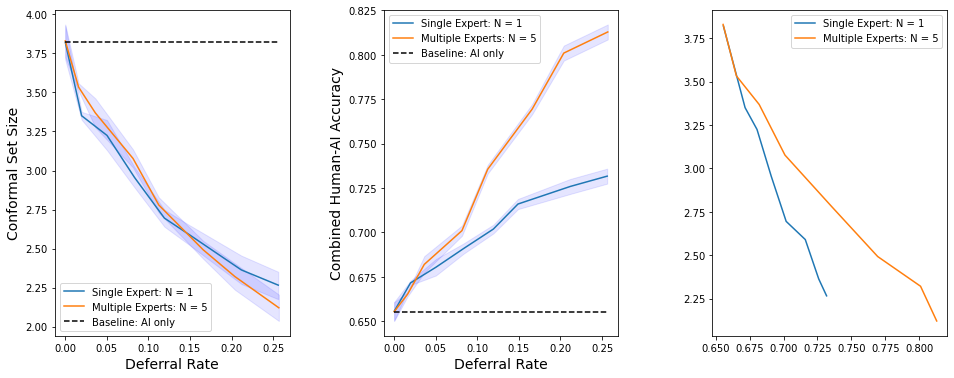

{'size': (array([3.75093333, 3.52395554, 3.07777675, 2.55414815, 2.32794569,
       2.29941226, 2.18743321]), array([25.87013333])), 'deferred_proportion': (array([0.        , 0.01746667, 0.0824    , 0.1704    , 0.2036    ,
       0.24586667, 0.27893333]), array([0., 0., 0., 0., 0., 0., 0.])), 'top-1': (array([0.654     , 0.66173889, 0.68472897, 0.7181893 , 0.73500266,
       0.74832003, 0.75739559]), array([4.564])), 'top-5': (array([0.90306667, 0.89450019, 0.90710755, 0.92300814, 0.92843179,
       0.93887688, 0.94256769]), array([6.314]))} 
 {'size': (array([0.06792842, 0.03347235, 0.1010782 , 0.03214908, 0.08400158,
       0.02720205, 0.05735896]), array([0.5519155])), 'deferred_proportion': (array([0.        , 0.00119753, 0.00282843, 0.00311555, 0.0088383 ,
       0.00467365, 0.00651107]), array([0.])), 'top-1': (array([0.00290287, 0.00356879, 0.00302401, 0.00365199, 0.00371252,
       0.00392641, 0.0027668 ]), array([0.0293963])), 'top-5': (array([0.00243189, 0.0022265 , 0.001021

In [ ]:
import matplotlib.pyplot as plt

defer = False # Whether to train a model with deferral or not
skew = False
# %% [code]
# if defer:
#   model_deferral = WideResNet(28, n_dataset + 1, 4, dropRate=0)
# else:
#   model_non_deferral = WideResNet(28, n_dataset, 4, dropRate=0)
# alpha = 1
# num_epochs = 10
# train_loader2,test_loader2,calibration_loader2,model_non_deferral = run_reject(model_non_deferral, True, n_dataset, expert.predict, num_epochs,alpha,defer,beta = 0) # train for 'num_epochs' epochs


cmodel_deferral = ConformalModel(model_deferral, calibration_loader, alpha=0.05, lamda = None, kreg = None, lamda_criterion='size',defer=True,LAC=False)
cmodel_non_deferral = ConformalModel(model_non_deferral, calibration_loader, alpha=0.05, lamda = None, kreg = None, lamda_criterion='size',defer=False,LAC=False)
# top1_deferral, top5_deferral, coverage_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(test_loader, cmodel_non_deferral, print_bool=True)
# top1_deferral, top5_deferral, coverage_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(test_loader, cmodel_deferral, print_bool=True)

set_sizes_def = []
set_sizes_non_def = []
ndef_indices = []

with torch.no_grad():
  for x,y in test_loader:
    x = x.cuda()
    y = y.cuda()
    scores_def, set_def,def_indices = cmodel_deferral(x.cuda())
    # set_sizes_def += [len(set_def[i]) for i in range(len(set_def))]
    # set_sizes_non_def += [len(set_non_def[i]) for i in range(len(set_non_def))]
    counter = 0
    for j in range(len(scores_def)):
      if j not in def_indices:
        ndef_indices.append(counter)
        set_sizes_def.append(len(set_def[counter]))
        counter += 1

with torch.no_grad():
  for x,y in test_loader:
    x = x.cuda()
    y = y.cuda()
    scores_non_def, set_non_def,_ = cmodel_non_deferral(x.cuda())
    # set_sizes_def += [len(set_def[i]) for i in range(len(set_def))]
    # set_sizes_non_def += [len(set_non_def[i]) for i in range(len(set_non_def))]
    counter = 0
    for j in range(len(scores_non_def)):
      if j not in def_indices:
        ndef_indices.append(counter)
        set_sizes_non_def.append(len(set_non_def[j]))
        counter += 1
      else:
        set_sizes_non_def.append(len(set_non_def[j]))


print(np.array(set_sizes_non_def).mean())

cmodel_deferral = ConformalModel(model_deferral, calibration_loader, alpha=0.05, lamda = None, kreg = None, lamda_criterion='size',defer=True,LAC=True)
cmodel_non_deferral = ConformalModel(model_non_deferral, calibration_loader, alpha=0.05, lamda = None, kreg = None, lamda_criterion='size',defer=False,LAC=True)
# top1_deferral, top5_deferral, coverage_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(test_loader, cmodel_non_deferral, print_bool=True)

set_sizes_def_lac = []
set_sizes_non_def_lac = []
ndef_indices = []

with torch.no_grad():
  for x,y in test_loader:
    x = x.cuda()
    y = y.cuda()
    scores_def, set_def,def_indices = cmodel_deferral(x.cuda())
    scores_non_def, set_non_def,_ = cmodel_non_deferral(x.cuda())
    # set_sizes_def += [len(set_def[i]) for i in range(len(set_def))]
    # set_sizes_non_def += [len(set_non_def[i]) for i in range(len(set_non_def))]
    counter = 0
    for j in range(len(scores_non_def)):
      if j not in def_indices:
        ndef_indices.append(counter)
        set_sizes_def_lac.append(len(set_def[counter]))
        set_sizes_non_def_lac.append(len(set_non_def[j]))
        counter += 1
      else:
        set_sizes_non_def_lac.append(len(set_non_def[j]))


cmodel_deferral = ConformalModel(model_deferral, calibration_loader, alpha=0.05, lamda = 0, kreg = 0, lamda_criterion='size',defer=True,LAC=False)
cmodel_non_deferral = ConformalModel(model_non_deferral, calibration_loader, alpha=0.05, lamda = 0, kreg = 0, lamda_criterion='size',defer=False,LAC=False)
# top1_deferral, top5_deferral, coverage_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(test_loader, cmodel_non_deferral, print_bool=True)

set_sizes_def_aps = []
set_sizes_non_def_aps = []
ndef_indices = []

with torch.no_grad():
  for x,y in test_loader:
    x = x.cuda()
    y = y.cuda()
    scores_def, set_def,def_indices = cmodel_deferral(x.cuda())
    scores_non_def, set_non_def,_ = cmodel_non_deferral(x.cuda())
    # set_sizes_def += [len(set_def[i]) for i in range(len(set_def))]
    # set_sizes_non_def += [len(set_non_def[i]) for i in range(len(set_non_def))]
    counter = 0
    for j in range(len(scores_non_def)):
      if j not in def_indices:
        ndef_indices.append(counter)
        set_sizes_def_aps.append(len(set_def[counter]))
        set_sizes_non_def_aps.append(len(set_non_def[j]))
        counter += 1
      else:
        set_sizes_non_def_aps.append(len(set_non_def[j]))


Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 47/47 [00:03<00:00, 13.87it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:235: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Optimal T=0.9578279852867126
5 0.01 <torch.utils.data.dataset.Subset object at 0x7f67d06ea790>
0.9628605246543884
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 47/47 [00:02<00:00, 17.18it/s]


Optimal T=1.0488876104354858
10 0.01 <torch.utils.data.dataset.Subset object at 0x7f67d06ea410>
0.9637575745582581
6.69775
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 47/47 [00:02<00:00, 16.65it/s]


Optimal T=0.9555337429046631
4860
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 47/47 [00:02<00:00, 17.26it/s]


Optimal T=1.045902132987976
6000
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 47/47 [00:02<00:00, 16.51it/s]


Optimal T=0.9529537558555603
0.9486865997314453
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 47/47 [00:02<00:00, 17.57it/s]


Optimal T=1.045258641242981
0.9474309682846069


5.521 7.85875 6.994833333333333


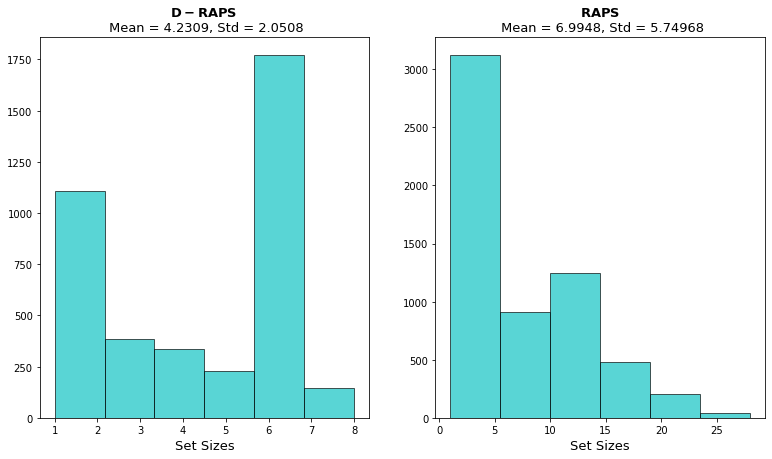

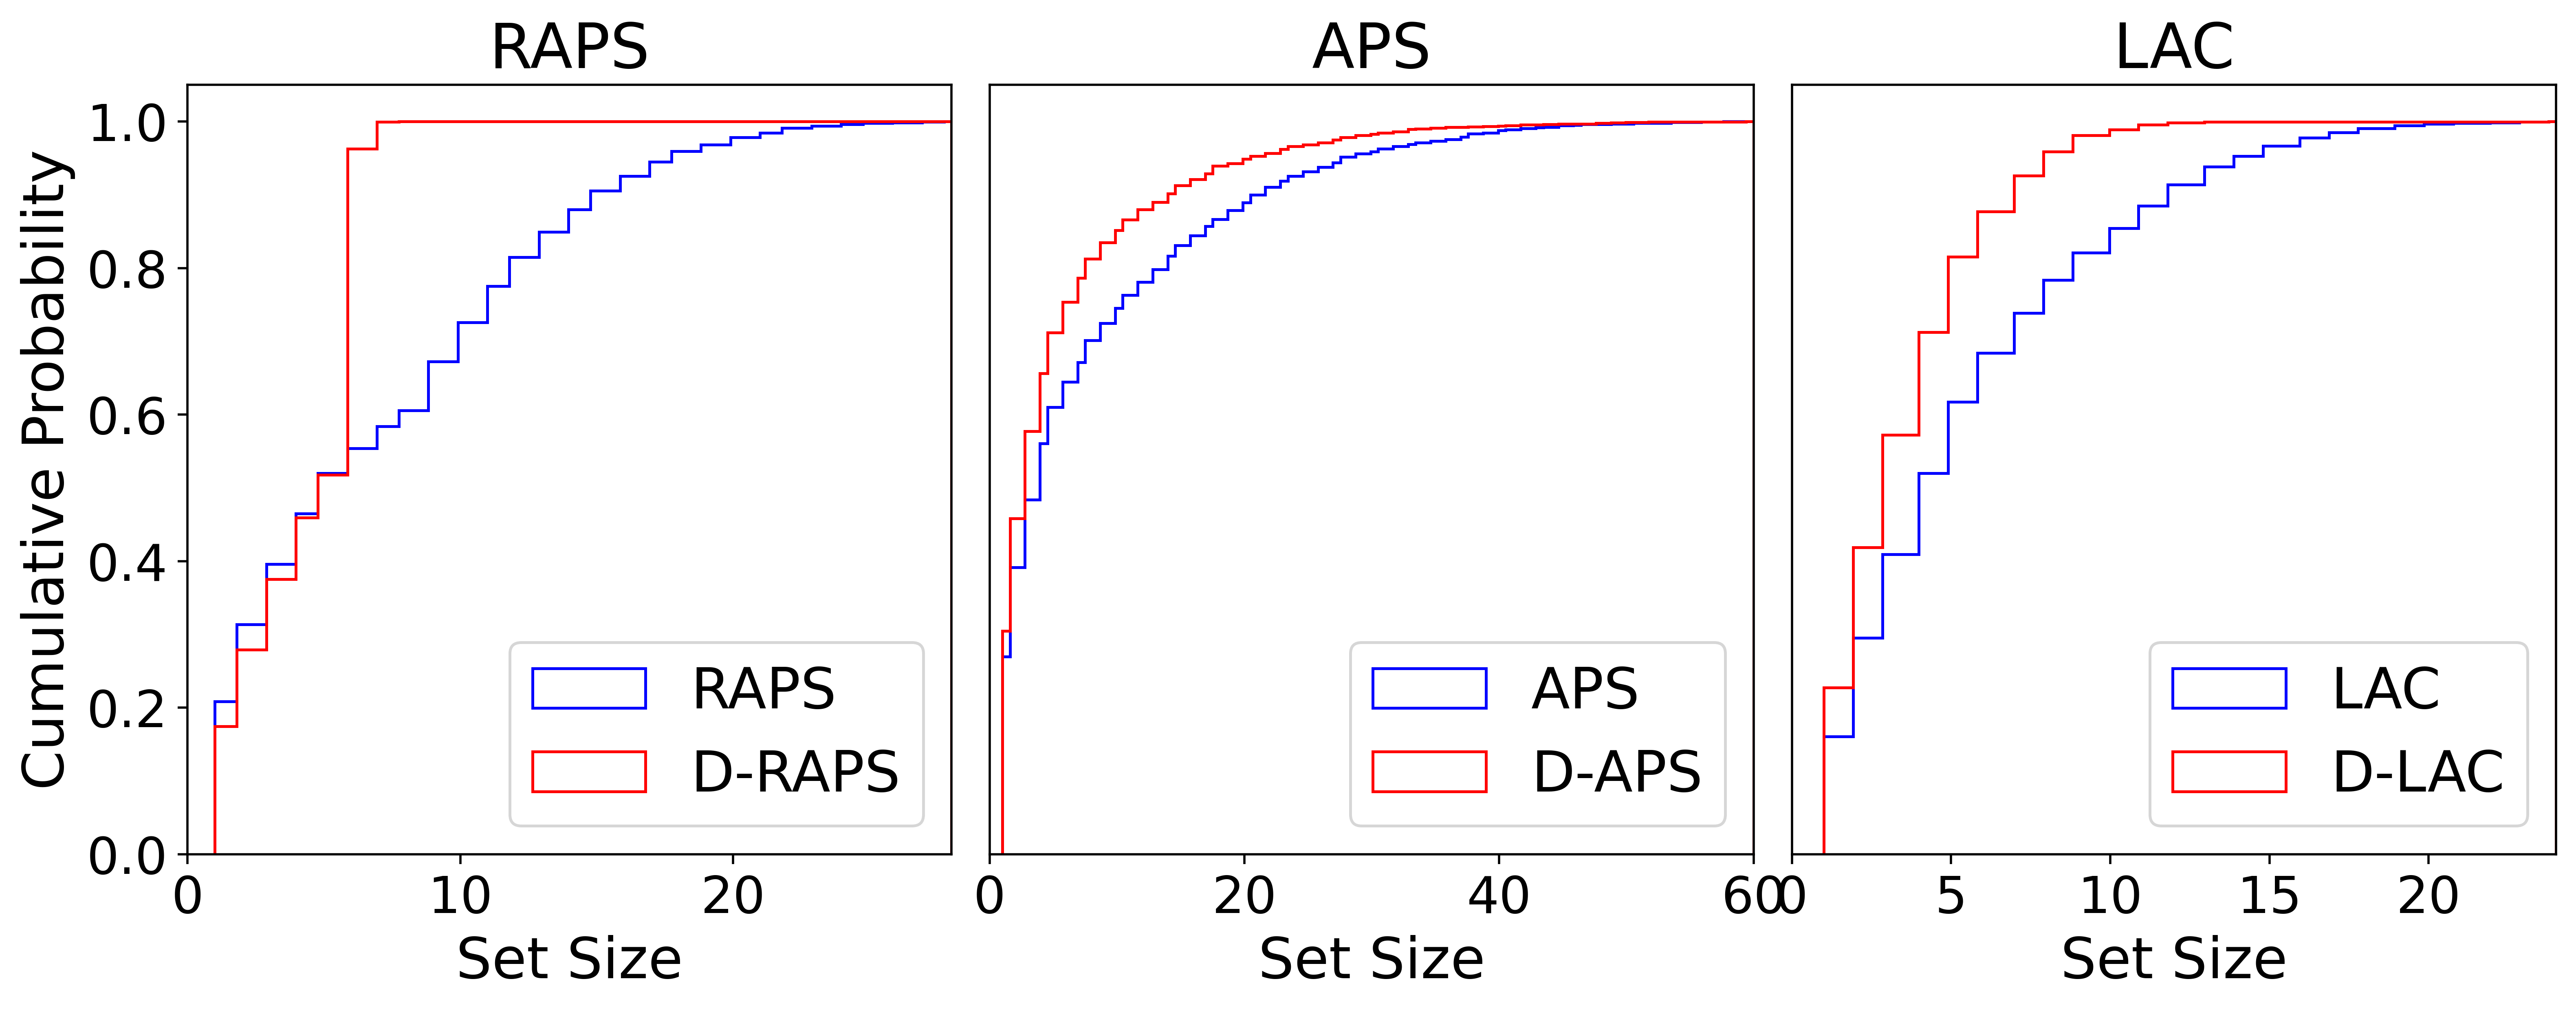

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(13,7))
ax[0].hist(set_sizes_def,bins=6, color='c', edgecolor='k', alpha=0.65)
# ax[0].axvline(0.95,color='k',linestyle='dashed', linewidth=3)
ax[0].set_xlabel("Set Sizes",size=13)
# ax[0].set_ylabel("Frequency",size=13)
# ax[0].legend([r'$1 - \alpha = 0.95$'],loc='upper left')
ax[0].set_title(r"$\bf{D-RAPS}$" + " \n Mean = {}, Std = {}".format(round(np.array(set_sizes_def).mean(),4),round(np.array(set_sizes_def).std(),5)),size=13)
# ax[0].set_xticks([0.935,0.940,0.945,0.950,0.955,0.960])
# ax[0].set_yticks([0,20,40,60])

ax[1].hist(set_sizes_non_def,bins=6, color='c', edgecolor='k', alpha=0.65)
# ax[1].axvline(0.95,color='k',linestyle='dashed', linewidth=3)
# ax[1].legend([r'$1 - \alpha = 0.95$'],loc='upper left')
ax[1].set_xlabel("Set Sizes",size=13)
ax[1].set_title(r"$\bf{RAPS}$" +  "\n Mean = {}, Std = {}".format(round(np.array(set_sizes_non_def).mean(),4),round(np.array(set_sizes_non_def).std(),5)),size=13)
# print(sum([1 for i in range(len(set_sizes_def)) if set_sizes_def[i] < set_sizes_non_def[i]]))

set_sizes_non_def = np.array(set_sizes_non_def)
set_sizes_def = np.array(set_sizes_def)

set_sizes_non_def_lac = np.array(set_sizes_non_def_lac)
set_sizes_def_lac = np.array(set_sizes_def_lac)

set_sizes_non_def_aps = np.array(set_sizes_non_def_aps)
set_sizes_def_aps = np.array(set_sizes_def_aps)
# set_sizes_def = set_sizes_def[:-1]
print(set_sizes_non_def_lac.mean(),set_sizes_non_def_aps.mean(),set_sizes_non_def.mean())
set_sizes_def = np.append(set_sizes_def,set_sizes_non_def.max())
set_sizes_def_aps = np.append(set_sizes_def_aps,set_sizes_non_def_aps.max())
set_sizes_def_lac = np.append(set_sizes_def_lac,set_sizes_non_def_lac.max())

# fig,ax = plt.subplots(1,1,figsize=(13,7))
sorted_data_def = np.sort(set_sizes_def)
sorted_data_ndef = np.sort(set_sizes_non_def)

sorted_data_def_aps = np.sort(set_sizes_def_aps)
sorted_data_ndef_aps = np.sort(set_sizes_non_def_aps)

sorted_data_def_lac = np.sort(set_sizes_def_lac)
sorted_data_ndef_lac = np.sort(set_sizes_non_def_lac)

n_bins = 100

fig, ax = plt.subplots(1,3,figsize=(15, 5))
fig.set_dpi(500)
# plot the cumulative histogram
n, bins, patches = ax[0].hist(sorted_data_ndef, n_bins, density=True, histtype='step',
                           cumulative=True, label='Empirical',color='b')
ax[0].set_title("RAPS".format(round(set_sizes_non_def.mean(),3)),fontsize=22)
n, bins, patches = ax[0].hist(sorted_data_def, n_bins, density=True, histtype='step',
                           cumulative=True, label='Empirical',color='r')

ax[0].set_xlim(0,sorted_data_ndef.max())
ax[0].set_xlabel("Set Size",fontsize=20)
ax[0].set_ylabel("Cumulative Probability",fontsize=20)
ax[0].legend(['RAPS','D-RAPS'],loc='lower right',fontsize=20)

# plot the cumulative histogram
n, bins, patches = ax[1].hist(sorted_data_ndef_aps, n_bins, density=True, histtype='step',
                           cumulative=True, label='Empirical',color='b')
ax[1].set_title("APS".format(round(set_sizes_non_def_aps.mean(),3)),fontsize=22)
n, bins, patches = ax[1].hist(sorted_data_def_aps, n_bins, density=True, histtype='step',
                           cumulative=True, label='Empirical',color='r')

ax[1].set_xlim(0,sorted_data_ndef_aps.max())
ax[1].set_xlabel("Set Size",fontsize=20)

# ax[1].set_ylabel("Cumulative Probability",fontsize=14)
ax[1].legend(['APS','D-APS'],loc='lower right',fontsize=20)

# plot the cumulative histogram
n, bins, patches = ax[2].hist(sorted_data_ndef_lac, n_bins, density=True, histtype='step',
                           cumulative=True, label='Empirical',color='b')

n, bins, patches = ax[2].hist(sorted_data_def_lac, n_bins, density=True, histtype='step',
                           cumulative=True, label='Empirical',color='r')

ax[2].set_xlim(0,sorted_data_ndef_lac.max())
# ax[2].set_xticks([0,5,10,15,20,25])
ax[2].set_xlabel("Set Size",fontsize=20)
ax[2].set_title("LAC".format(round(sorted_data_ndef_lac.mean(),3)),fontsize=22)
# ax[2].set_ylabel("Cumulative Probability",fontsize=14)
ax[2].legend(['LAC','D-LAC'],loc='lower right',fontsize=20)
ax[1].set_yticks([])
ax[2].set_yticks([])
for axs in ax:
  axs.tick_params(axis='both', which='major', labelsize=18)
  axs.tick_params(axis='both', which='minor', labelsize=18)
plt.subplots_adjust(wspace=0.05)
plt.show()


In [ ]:
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
])
n_dataset = 100
if n_dataset == 10:
    dataset = 'cifar10'
elif n_dataset == 100:
    dataset = 'cifar100'

kwargs = {'num_workers': 0, 'pin_memory': True}

val_dataset_all = datasets.__dict__[dataset.upper()]('../data', train=False, download=True,
                                                        transform=transform_test)
test_size = int(0.4 * len(val_dataset_all)) 
calibration_size = len(val_dataset_all) - test_size
test_dataset, calibration_dataset = torch.utils.data.random_split(val_dataset_all, [test_size,calibration_size],generator=torch.Generator().manual_seed(42))
test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=128, shuffle=True, **kwargs)
calibration_loader = torch.utils.data.DataLoader(calibration_dataset,
                                              batch_size=128, shuffle=True, **kwargs)




Files already downloaded and verified


In [ ]:
n = 200
lac_coverage = []
aps_coverage = []
raps_coverage = []
dlac_coverage = []
daps_coverage = []
draps_coverage = []
# model_deferral = WideResNet(28, n_dataset + 1, 4, dropRate=0).cuda()
# model_non_deferral = WideResNet(28, n_dataset, 4, dropRate=0).cuda()
# alpha = 1
# num_epochs = 10
# _,_,_,model_deferral = run_reject(model_deferral, True, n_dataset, expert.predict, num_epochs,alpha,defer=True,beta = 0.5) # train for 'num_epochs' epochs
# _,_,_,model_non_deferral = run_reject(model_non_deferral, True, n_dataset, expert.predict, num_epochs,alpha,defer=False,beta = 0) # train for 'num_epochs' epochs


for i in range(n):
  test_dataset, calibration_dataset = torch.utils.data.random_split(val_dataset_all, [test_size,calibration_size],generator=torch.Generator().manual_seed(42))

  test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=128, shuffle=True, **kwargs)
  calibration_loader = torch.utils.data.DataLoader(calibration_dataset,
                                              batch_size=128, shuffle=True, **kwargs)
  
  cmodel_deferral = ConformalModel(model_deferral, calibration_loader, alpha=0.05, lamda = None, kreg = None, randomized=True,lamda_criterion='size',defer=True,LAC=False,allow_zero_sets=True)
  cmodel_non_deferral = ConformalModel(model_non_deferral, calibration_loader, alpha=0.05, lamda = None, randomized=True,kreg = None, lamda_criterion='size',defer=False,LAC=False,allow_zero_sets=True)
  top1_deferral, top5_deferral, coverage_non_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(calibration_loader, cmodel_non_deferral, print_bool=True)
  raps_coverage.append(coverage_non_deferral)
  top1_deferral, top5_deferral, coverage_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(calibration_loader, cmodel_deferral, print_bool=True)
  draps_coverage.append(coverage_deferral)


  cmodel_deferral = ConformalModel(model_deferral, calibration_loader, alpha=0.05, lamda = None, kreg = None, randomized=True,lamda_criterion='size',defer=True,LAC=True,allow_zero_sets=True)
  cmodel_non_deferral = ConformalModel(model_non_deferral, calibration_loader, alpha=0.05, lamda = None, randomized=True,kreg = None, lamda_criterion='size',defer=False,LAC=True,allow_zero_sets=True)
  top1_deferral, top5_deferral, coverage_non_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(test_loader, cmodel_non_deferral, print_bool=True)
  lac_coverage.append(coverage_non_deferral)
  top1_deferral, top5_deferral, coverage_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(test_loader, cmodel_deferral, print_bool=True)
  dlac_coverage.append(coverage_deferral)

  
  cmodel_deferral = ConformalModel(model_deferral, calibration_loader, alpha=0.05, lamda = 0, kreg = 0, randomized=True,lamda_criterion='size',defer=True,LAC=False,allow_zero_sets=True)
  cmodel_non_deferral = ConformalModel(model_non_deferral, calibration_loader, alpha=0.05, lamda = 0, kreg = 0, randomized=True,lamda_criterion='size',defer=False,LAC=False,allow_zero_sets=True)
  top1_deferral, top5_deferral, coverage_non_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(calibration_loader, cmodel_non_deferral, print_bool=True)
  aps_coverage.append(coverage_non_deferral)
  top1_deferral, top5_deferral, coverage_deferral, size_deferral,cmodel_deferral_percentage_not_deferred = validate(calibration_loader, cmodel_deferral, print_bool=True)
  daps_coverage.append(coverage_deferral)
  print('Trial: {}'.format(i),round(np.array(daps_coverage).mean(),4),round(np.array(daps_coverage).std(),4))

fig,ax = plt.subplots(2,3,figsize=(13,7))
fig.set_dpi(500)
ax[0][0].hist(draps_coverage,bins=6, color='c', edgecolor='k', alpha=0.65)
ax[0][0].set_title(r'$\bf{D-RAPS}$' + '\n Mean = {}, Std = {}'.format(round(np.array(draps_coverage).mean(),4),round(np.array(draps_coverage).std(),4)))
for axs in ax:
  for ax2 in axs:
    ax2.set_xlabel("Empirical Coverage",fontsize=12)
    ax2.set_xlim(0.935,0.965)
    ax2.set_ylim(0,70)
    ax2.set_yticks([0,20,40,60])
ax[0][0].set_ylabel("Frequency",fontsize=12)
ax[1][0].set_ylabel("Frequency",fontsize=12)
ax[0][1].hist(daps_coverage,bins=6, color='c', edgecolor='k', alpha=0.65)
ax[0][1].set_title(r'$\bf{D-APS}$' + '\n Mean = {}, Std = {}'.format(round(np.array(daps_coverage).mean(),4),round(np.array(daps_coverage).std(),4)))
ax[0][2].hist(dlac_coverage,bins=6, color='c', edgecolor='k', alpha=0.65)
ax[0][2].set_title(r'$\bf{D-LAC}$' + '\n Mean = {}, Std = {}'.format(round(np.array(dlac_coverage).mean(),4),round(np.array(dlac_coverage).std(),4)))
ax[1][0].hist(raps_coverage,bins=6, color='c', edgecolor='k', alpha=0.65)
ax[1][0].set_title(r'$\bf{RAPS}$' + '\n Mean = {}, Std = {}'.format(round(np.array(raps_coverage).mean(),4),round(np.array(raps_coverage).std(),4)))
ax[1][1].hist(aps_coverage,bins=6, color='c', edgecolor='k', alpha=0.65)
ax[1][1].set_title(r'$\bf{APS}$' + '\n Mean = {}, Std = {}'.format(round(np.array(aps_coverage).mean(),4),round(np.array(aps_coverage).std(),4)))
ax[1][2].hist(lac_coverage,bins=6, color='c', edgecolor='k', alpha=0.65)
ax[1][2].set_title(r'$\bf{LAC}$' + '\n Mean = {}, Std = {}'.format(round(np.array(lac_coverage).mean(),4),round(np.array(lac_coverage).std(),4)))
plt.subplots_adjust(hspace = 0.5)




Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:03<00:00,  8.36it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:235: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Optimal T=0.9579534530639648
8 0.2 <torch.utils.data.dataset.Subset object at 0x7f68aabd9790>
0.969914972782135
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.02it/s]


Optimal T=1.0458357334136963
10 0.01 <torch.utils.data.dataset.Subset object at 0x7f67d68ef0d0>
0.9649451971054077
N: 4000 | Time: 0.019 (0.066) | Cvg@1: 0.688 (0.665) | Cvg@5: 0.938 (0.902) | Cvg@RAPS: 0.969 (0.952) | Size@RAPS: 8.750 (6.803)
N: 4000 | Time: 0.024 (0.076) | Cvg@1: 0.600 (0.739) | Cvg@5: 0.933 (0.932) | Cvg@RAPS: 1.000 (0.950) | Size@RAPS: 5.367 (4.385)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.76it/s]


Optimal T=0.9526539444923401
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.35it/s]


Optimal T=1.0613139867782593
4000
N: 6000 | Time: 0.176 (0.069) | Cvg@1: 0.562 (0.662) | Cvg@5: 0.938 (0.910) | Cvg@RAPS: 0.973 (0.954) | Size@RAPS: 6.027 (5.469)
N: 6000 | Time: 0.067 (0.075) | Cvg@1: 0.670 (0.741) | Cvg@5: 0.923 (0.931) | Cvg@RAPS: 0.934 (0.951) | Size@RAPS: 3.714 (3.532)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.94it/s]


Optimal T=0.9560831785202026
0.9491784572601318
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.80it/s]


Optimal T=1.0485036373138428
0.9475312829017639
N: 4000 | Time: 0.021 (0.063) | Cvg@1: 0.719 (0.665) | Cvg@5: 0.906 (0.902) | Cvg@RAPS: 0.969 (0.952) | Size@RAPS: 11.562 (8.176)
N: 4000 | Time: 0.023 (0.074) | Cvg@1: 0.538 (0.739) | Cvg@5: 0.808 (0.932) | Cvg@RAPS: 0.885 (0.947) | Size@RAPS: 6.654 (5.484)
Trial: 0 0.9474 0.0
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.13it/s]


Optimal T=0.9517064094543457
6 0.2 <torch.utils.data.dataset.Subset object at 0x7f68aabd97d0>
0.976816713809967
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.81it/s]


Optimal T=1.0455904006958008
9 0.01 <torch.utils.data.dataset.Subset object at 0x7f67d68efb10>
0.9671187996864319
N: 4000 | Time: 0.025 (0.067) | Cvg@1: 0.688 (0.665) | Cvg@5: 0.875 (0.902) | Cvg@RAPS: 0.969 (0.952) | Size@RAPS: 6.156 (6.712)
N: 4000 | Time: 0.022 (0.074) | Cvg@1: 0.552 (0.739) | Cvg@5: 0.793 (0.932) | Cvg@RAPS: 0.897 (0.950) | Size@RAPS: 4.621 (3.922)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.10it/s]


Optimal T=0.9601487517356873
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 18.14it/s]


Optimal T=1.0509859323501587
4000
N: 6000 | Time: 0.068 (0.065) | Cvg@1: 0.670 (0.663) | Cvg@5: 0.973 (0.910) | Cvg@RAPS: 0.973 (0.954) | Size@RAPS: 5.357 (5.474)
N: 6000 | Time: 0.065 (0.075) | Cvg@1: 0.682 (0.741) | Cvg@5: 0.847 (0.931) | Cvg@RAPS: 0.882 (0.951) | Size@RAPS: 3.847 (3.541)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.10it/s]


Optimal T=0.9621989727020264
0.9507802724838257
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.92it/s]


Optimal T=1.0515040159225464
0.9460180401802063
N: 4000 | Time: 0.024 (0.064) | Cvg@1: 0.750 (0.665) | Cvg@5: 0.875 (0.902) | Cvg@RAPS: 0.969 (0.949) | Size@RAPS: 8.844 (8.086)
N: 4000 | Time: 0.022 (0.074) | Cvg@1: 0.704 (0.739) | Cvg@5: 0.852 (0.932) | Cvg@RAPS: 0.926 (0.955) | Size@RAPS: 5.444 (5.696)
Trial: 1 0.9511 0.0037
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.18it/s]


Optimal T=0.9534426331520081
5 0.1 <torch.utils.data.dataset.Subset object at 0x7f68aabd9450>
0.9845835566520691
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.93it/s]


Optimal T=1.0533409118652344
9 0.01 <torch.utils.data.dataset.Subset object at 0x7f68aabd9890>
0.9667282104492188
N: 4000 | Time: 0.019 (0.066) | Cvg@1: 0.719 (0.665) | Cvg@5: 0.844 (0.902) | Cvg@RAPS: 0.906 (0.953) | Size@RAPS: 6.531 (6.769)
N: 4000 | Time: 0.023 (0.075) | Cvg@1: 0.769 (0.738) | Cvg@5: 0.962 (0.932) | Cvg@RAPS: 0.962 (0.948) | Size@RAPS: 4.269 (3.907)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.82it/s]


Optimal T=0.95176762342453
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.62it/s]


Optimal T=1.0510154962539673
4000
N: 6000 | Time: 0.058 (0.064) | Cvg@1: 0.598 (0.662) | Cvg@5: 0.902 (0.910) | Cvg@RAPS: 0.955 (0.954) | Size@RAPS: 5.554 (5.474)
N: 6000 | Time: 0.074 (0.076) | Cvg@1: 0.703 (0.741) | Cvg@5: 0.956 (0.931) | Cvg@RAPS: 0.967 (0.951) | Size@RAPS: 3.495 (3.528)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.74it/s]


Optimal T=0.9454817175865173
0.9523997902870178
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.76it/s]


Optimal T=1.0485970973968506
0.9478861093521118
N: 4000 | Time: 0.024 (0.066) | Cvg@1: 0.625 (0.665) | Cvg@5: 0.844 (0.902) | Cvg@RAPS: 0.906 (0.950) | Size@RAPS: 9.562 (8.201)
N: 4000 | Time: 0.023 (0.076) | Cvg@1: 0.880 (0.739) | Cvg@5: 1.000 (0.932) | Cvg@RAPS: 1.000 (0.947) | Size@RAPS: 3.120 (5.534)
Trial: 2 0.9498 0.0035
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.93it/s]


Optimal T=0.9578151702880859
6 0.2 <torch.utils.data.dataset.Subset object at 0x7f68aabd9e10>
0.9711560010910034
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.89it/s]


Optimal T=1.0577343702316284
10 0.01 <torch.utils.data.dataset.Subset object at 0x7f67d68d44d0>
0.9584572315216064
N: 4000 | Time: 0.020 (0.066) | Cvg@1: 0.625 (0.665) | Cvg@5: 0.875 (0.902) | Cvg@RAPS: 1.000 (0.949) | Size@RAPS: 6.156 (6.622)
N: 4000 | Time: 0.022 (0.076) | Cvg@1: 0.724 (0.739) | Cvg@5: 0.931 (0.933) | Cvg@RAPS: 0.966 (0.944) | Size@RAPS: 4.103 (3.789)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:02<00:00, 15.72it/s]


Optimal T=0.9484060406684875
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.95it/s]


Optimal T=1.0564725399017334
4000
N: 6000 | Time: 0.057 (0.065) | Cvg@1: 0.679 (0.662) | Cvg@5: 0.902 (0.910) | Cvg@RAPS: 0.955 (0.954) | Size@RAPS: 5.268 (5.471)
N: 6000 | Time: 0.066 (0.074) | Cvg@1: 0.739 (0.741) | Cvg@5: 0.924 (0.931) | Cvg@RAPS: 0.924 (0.951) | Size@RAPS: 3.293 (3.522)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.89it/s]


Optimal T=0.9529595375061035
0.9516225457191467
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.80it/s]


Optimal T=1.04951810836792
0.9514859914779663
N: 4000 | Time: 0.019 (0.064) | Cvg@1: 0.594 (0.665) | Cvg@5: 0.875 (0.902) | Cvg@RAPS: 0.938 (0.954) | Size@RAPS: 9.812 (8.533)
N: 4000 | Time: 0.022 (0.074) | Cvg@1: 0.615 (0.739) | Cvg@5: 0.923 (0.932) | Cvg@RAPS: 1.000 (0.950) | Size@RAPS: 5.769 (5.598)
Trial: 3 0.9499 0.0031
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.82it/s]


Optimal T=0.9526121616363525
5 0.1 <torch.utils.data.dataset.Subset object at 0x7f67d68d4950>
0.9880834817886353
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.96it/s]


Optimal T=1.0467885732650757
10 0.01 <torch.utils.data.dataset.Subset object at 0x7f68aabd9ed0>
0.9631460309028625
N: 4000 | Time: 0.020 (0.065) | Cvg@1: 0.594 (0.665) | Cvg@5: 0.875 (0.902) | Cvg@RAPS: 0.969 (0.951) | Size@RAPS: 5.812 (6.731)
N: 4000 | Time: 0.024 (0.075) | Cvg@1: 0.640 (0.739) | Cvg@5: 0.920 (0.932) | Cvg@RAPS: 0.920 (0.952) | Size@RAPS: 4.440 (4.050)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.68it/s]


Optimal T=0.9611982703208923
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.27it/s]


Optimal T=1.044411301612854
4000
N: 6000 | Time: 0.055 (0.066) | Cvg@1: 0.714 (0.663) | Cvg@5: 0.938 (0.910) | Cvg@RAPS: 0.964 (0.955) | Size@RAPS: 5.152 (5.483)
N: 6000 | Time: 0.068 (0.075) | Cvg@1: 0.738 (0.741) | Cvg@5: 0.940 (0.931) | Cvg@RAPS: 0.952 (0.951) | Size@RAPS: 3.524 (3.544)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.25it/s]


Optimal T=0.9469534158706665
0.9536861777305603
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.83it/s]


Optimal T=1.0535895824432373
0.9482579231262207
N: 4000 | Time: 0.019 (0.063) | Cvg@1: 0.688 (0.665) | Cvg@5: 0.875 (0.902) | Cvg@RAPS: 0.938 (0.951) | Size@RAPS: 7.375 (8.314)
N: 4000 | Time: 0.030 (0.074) | Cvg@1: 0.591 (0.739) | Cvg@5: 0.818 (0.932) | Cvg@RAPS: 0.818 (0.948) | Size@RAPS: 5.182 (5.637)
Trial: 4 0.9495 0.0029
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.49it/s]


Optimal T=0.9520559906959534
6 0.1 <torch.utils.data.dataset.Subset object at 0x7f67d68d4390>
0.9746206998825073
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.83it/s]


Optimal T=1.054335594177246
11 0.1 <torch.utils.data.dataset.Subset object at 0x7f68aabd9050>
0.9810875654220581
N: 4000 | Time: 0.019 (0.066) | Cvg@1: 0.562 (0.665) | Cvg@5: 0.875 (0.902) | Cvg@RAPS: 0.938 (0.950) | Size@RAPS: 6.656 (6.712)
N: 4000 | Time: 0.022 (0.075) | Cvg@1: 0.808 (0.738) | Cvg@5: 0.923 (0.932) | Cvg@RAPS: 0.923 (0.946) | Size@RAPS: 3.846 (3.958)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.54it/s]


Optimal T=0.9447104930877686
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.62it/s]


Optimal T=1.0595287084579468
4000
N: 6000 | Time: 0.059 (0.066) | Cvg@1: 0.688 (0.662) | Cvg@5: 0.911 (0.910) | Cvg@RAPS: 0.946 (0.954) | Size@RAPS: 5.232 (5.471)
N: 6000 | Time: 0.065 (0.075) | Cvg@1: 0.800 (0.741) | Cvg@5: 0.944 (0.931) | Cvg@RAPS: 0.978 (0.951) | Size@RAPS: 3.033 (3.522)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.84it/s]


Optimal T=0.9513184428215027
0.9536886215209961
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.48it/s]


Optimal T=1.0495222806930542
0.9471532702445984
N: 4000 | Time: 0.021 (0.066) | Cvg@1: 0.562 (0.665) | Cvg@5: 0.969 (0.902) | Cvg@RAPS: 0.969 (0.951) | Size@RAPS: 12.594 (8.149)
N: 4000 | Time: 0.026 (0.075) | Cvg@1: 0.773 (0.739) | Cvg@5: 0.909 (0.932) | Cvg@RAPS: 0.955 (0.953) | Size@RAPS: 7.136 (5.725)
Trial: 5 0.95 0.0029
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.72it/s]


Optimal T=0.9473745226860046
7 0.5 <torch.utils.data.dataset.Subset object at 0x7f68aabd9a90>
0.9704160094261169
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.43it/s]


Optimal T=1.0536258220672607
8 0.01 <torch.utils.data.dataset.Subset object at 0x7f67d68d4bd0>
0.9732223153114319
N: 4000 | Time: 0.022 (0.067) | Cvg@1: 0.656 (0.665) | Cvg@5: 0.875 (0.902) | Cvg@RAPS: 0.938 (0.954) | Size@RAPS: 6.906 (6.887)
N: 4000 | Time: 0.023 (0.077) | Cvg@1: 0.926 (0.739) | Cvg@5: 0.926 (0.932) | Cvg@RAPS: 1.000 (0.947) | Size@RAPS: 3.000 (4.020)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.21it/s]


Optimal T=0.9510083794593811
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.20it/s]


Optimal T=1.0526394844055176
4000
N: 6000 | Time: 0.058 (0.065) | Cvg@1: 0.696 (0.662) | Cvg@5: 0.946 (0.910) | Cvg@RAPS: 0.991 (0.954) | Size@RAPS: 5.616 (5.472)
N: 6000 | Time: 0.067 (0.081) | Cvg@1: 0.705 (0.741) | Cvg@5: 0.937 (0.931) | Cvg@RAPS: 0.979 (0.951) | Size@RAPS: 3.495 (3.530)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.94it/s]


Optimal T=0.9498141407966614
0.9553428292274475
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.70it/s]


Optimal T=1.0531796216964722
0.9464958310127258
N: 4000 | Time: 0.019 (0.065) | Cvg@1: 0.594 (0.665) | Cvg@5: 0.906 (0.902) | Cvg@RAPS: 0.812 (0.950) | Size@RAPS: 7.281 (8.156)
N: 4000 | Time: 0.022 (0.074) | Cvg@1: 0.682 (0.739) | Cvg@5: 0.864 (0.932) | Cvg@RAPS: 0.909 (0.952) | Size@RAPS: 6.409 (5.825)
Trial: 6 0.9503 0.0028
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.43it/s]


Optimal T=0.9516111016273499
6 0.2 <torch.utils.data.dataset.Subset object at 0x7f67d68d4fd0>
0.9796463251113892
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.88it/s]


Optimal T=1.0519627332687378
11 0.2 <torch.utils.data.dataset.Subset object at 0x7f68aabd9cd0>
0.9805163145065308
N: 4000 | Time: 0.021 (0.065) | Cvg@1: 0.656 (0.665) | Cvg@5: 0.906 (0.902) | Cvg@RAPS: 0.875 (0.949) | Size@RAPS: 6.594 (6.540)
N: 4000 | Time: 0.022 (0.075) | Cvg@1: 0.667 (0.738) | Cvg@5: 0.875 (0.932) | Cvg@RAPS: 0.917 (0.951) | Size@RAPS: 4.500 (4.025)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.07it/s]


Optimal T=0.9492573142051697
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.72it/s]


Optimal T=1.0530451536178589
4000
N: 6000 | Time: 0.056 (0.066) | Cvg@1: 0.625 (0.662) | Cvg@5: 0.902 (0.910) | Cvg@RAPS: 0.946 (0.954) | Size@RAPS: 6.116 (5.472)
N: 6000 | Time: 0.066 (0.075) | Cvg@1: 0.670 (0.741) | Cvg@5: 0.928 (0.931) | Cvg@RAPS: 0.938 (0.951) | Size@RAPS: 3.371 (3.523)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.03it/s]


Optimal T=0.9559174180030823
0.9508062601089478
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.68it/s]


Optimal T=1.0521564483642578
0.9480185508728027
N: 4000 | Time: 0.026 (0.065) | Cvg@1: 0.625 (0.665) | Cvg@5: 0.906 (0.902) | Cvg@RAPS: 0.969 (0.953) | Size@RAPS: 12.031 (8.267)
N: 4000 | Time: 0.021 (0.074) | Cvg@1: 0.818 (0.739) | Cvg@5: 0.955 (0.932) | Cvg@RAPS: 1.000 (0.947) | Size@RAPS: 4.591 (5.579)
Trial: 7 0.9499 0.0028
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.88it/s]


Optimal T=0.9586620926856995
5 0.1 <torch.utils.data.dataset.Subset object at 0x7f67d68d4ad0>
0.9936418533325195
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.66it/s]


Optimal T=1.0588493347167969
11 0.1 <torch.utils.data.dataset.Subset object at 0x7f67d68d4ed0>
0.9769660234451294
N: 4000 | Time: 0.022 (0.065) | Cvg@1: 0.594 (0.665) | Cvg@5: 0.844 (0.902) | Cvg@RAPS: 0.938 (0.950) | Size@RAPS: 6.906 (6.505)
N: 4000 | Time: 0.022 (0.075) | Cvg@1: 0.733 (0.739) | Cvg@5: 0.933 (0.932) | Cvg@RAPS: 0.967 (0.954) | Size@RAPS: 4.667 (4.355)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.91it/s]


Optimal T=0.9573208689689636
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.50it/s]


Optimal T=1.0574918985366821
4000
N: 6000 | Time: 0.058 (0.066) | Cvg@1: 0.652 (0.663) | Cvg@5: 0.929 (0.910) | Cvg@RAPS: 0.955 (0.954) | Size@RAPS: 5.607 (5.469)
N: 6000 | Time: 0.066 (0.076) | Cvg@1: 0.726 (0.741) | Cvg@5: 0.958 (0.931) | Cvg@RAPS: 0.958 (0.951) | Size@RAPS: 3.168 (3.533)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.54it/s]


Optimal T=0.9562997221946716
0.9511014819145203
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.93it/s]


Optimal T=1.0513278245925903
0.9461028575897217
N: 4000 | Time: 0.020 (0.064) | Cvg@1: 0.562 (0.665) | Cvg@5: 0.812 (0.902) | Cvg@RAPS: 0.906 (0.946) | Size@RAPS: 9.344 (8.088)
N: 4000 | Time: 0.024 (0.075) | Cvg@1: 0.828 (0.738) | Cvg@5: 0.966 (0.932) | Cvg@RAPS: 0.966 (0.951) | Size@RAPS: 4.103 (5.618)
Trial: 8 0.9501 0.0027
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.04it/s]


Optimal T=0.9484147429466248
5 0.1 <torch.utils.data.dataset.Subset object at 0x7f68aabd9450>
0.9866962432861328
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.58it/s]


Optimal T=1.0501389503479004
12 0.5 <torch.utils.data.dataset.Subset object at 0x7f67d68d4c50>
0.9683087468147278
N: 4000 | Time: 0.020 (0.067) | Cvg@1: 0.812 (0.665) | Cvg@5: 0.969 (0.902) | Cvg@RAPS: 0.969 (0.945) | Size@RAPS: 4.875 (6.209)
N: 4000 | Time: 0.022 (0.074) | Cvg@1: 0.769 (0.738) | Cvg@5: 0.962 (0.932) | Cvg@RAPS: 0.962 (0.951) | Size@RAPS: 3.923 (3.963)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.95it/s]


Optimal T=0.9512319564819336
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.75it/s]


Optimal T=1.055208444595337
4000
N: 6000 | Time: 0.056 (0.065) | Cvg@1: 0.625 (0.662) | Cvg@5: 0.893 (0.910) | Cvg@RAPS: 0.938 (0.954) | Size@RAPS: 6.205 (5.470)
N: 6000 | Time: 0.067 (0.075) | Cvg@1: 0.739 (0.741) | Cvg@5: 0.966 (0.931) | Cvg@RAPS: 0.977 (0.951) | Size@RAPS: 3.500 (3.528)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.21it/s]


Optimal T=0.9539445638656616
0.9455724358558655
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 18.12it/s]


Optimal T=1.0479775667190552
0.9481630921363831
N: 4000 | Time: 0.028 (0.064) | Cvg@1: 0.688 (0.665) | Cvg@5: 0.969 (0.902) | Cvg@RAPS: 0.969 (0.951) | Size@RAPS: 7.938 (8.212)
N: 4000 | Time: 0.038 (0.076) | Cvg@1: 0.759 (0.739) | Cvg@5: 0.966 (0.932) | Cvg@RAPS: 0.931 (0.946) | Size@RAPS: 5.379 (5.223)
Trial: 9 0.9496 0.0029
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.08it/s]


Optimal T=0.9549298286437988
5 0.01 <torch.utils.data.dataset.Subset object at 0x7f67d68e1390>
0.9619093537330627
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.73it/s]


Optimal T=1.0456387996673584
11 0.1 <torch.utils.data.dataset.Subset object at 0x7f68aabd9b50>
0.9838004112243652
N: 4000 | Time: 0.019 (0.067) | Cvg@1: 0.625 (0.665) | Cvg@5: 0.938 (0.902) | Cvg@RAPS: 0.969 (0.951) | Size@RAPS: 7.625 (6.827)
N: 4000 | Time: 0.023 (0.076) | Cvg@1: 0.565 (0.738) | Cvg@5: 0.870 (0.932) | Cvg@RAPS: 0.957 (0.948) | Size@RAPS: 5.609 (4.316)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.37it/s]


Optimal T=0.959708571434021
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.66it/s]


Optimal T=1.0459518432617188
4000
N: 6000 | Time: 0.054 (0.065) | Cvg@1: 0.652 (0.663) | Cvg@5: 0.857 (0.910) | Cvg@RAPS: 0.911 (0.954) | Size@RAPS: 5.920 (5.480)
N: 6000 | Time: 0.071 (0.075) | Cvg@1: 0.730 (0.741) | Cvg@5: 0.933 (0.931) | Cvg@RAPS: 0.933 (0.951) | Size@RAPS: 3.663 (3.538)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.78it/s]


Optimal T=0.9603821039199829
0.9500089883804321
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.62it/s]


Optimal T=1.051836371421814
0.9490674734115601
N: 4000 | Time: 0.019 (0.065) | Cvg@1: 0.656 (0.665) | Cvg@5: 0.875 (0.902) | Cvg@RAPS: 0.969 (0.952) | Size@RAPS: 8.656 (8.354)
N: 4000 | Time: 0.022 (0.073) | Cvg@1: 0.852 (0.738) | Cvg@5: 0.963 (0.932) | Cvg@RAPS: 1.000 (0.948) | Size@RAPS: 6.259 (5.597)
Trial: 10 0.9495 0.0028
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.55it/s]


Optimal T=0.9448349475860596
5 0.1 <torch.utils.data.dataset.Subset object at 0x7f68aabd90d0>
0.991143524646759
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.63it/s]


Optimal T=1.053154468536377
10 0.01 <torch.utils.data.dataset.Subset object at 0x7f67d68d0ad0>
0.9614816308021545
N: 4000 | Time: 0.019 (0.066) | Cvg@1: 0.781 (0.665) | Cvg@5: 0.875 (0.902) | Cvg@RAPS: 0.969 (0.950) | Size@RAPS: 6.062 (6.723)
N: 4000 | Time: 0.022 (0.075) | Cvg@1: 0.690 (0.739) | Cvg@5: 0.966 (0.932) | Cvg@RAPS: 0.966 (0.953) | Size@RAPS: 4.448 (4.163)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.89it/s]


Optimal T=0.9497134685516357
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.51it/s]


Optimal T=1.0485310554504395
4000
N: 6000 | Time: 0.056 (0.064) | Cvg@1: 0.670 (0.663) | Cvg@5: 0.902 (0.910) | Cvg@RAPS: 0.929 (0.954) | Size@RAPS: 5.116 (5.478)
N: 6000 | Time: 0.062 (0.076) | Cvg@1: 0.788 (0.740) | Cvg@5: 0.953 (0.931) | Cvg@RAPS: 1.000 (0.951) | Size@RAPS: 3.306 (3.527)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.79it/s]


Optimal T=0.9575319290161133
0.9515029788017273
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.88it/s]


Optimal T=1.048583984375
0.9489805698394775
N: 4000 | Time: 0.024 (0.066) | Cvg@1: 0.562 (0.665) | Cvg@5: 0.781 (0.902) | Cvg@RAPS: 0.812 (0.951) | Size@RAPS: 9.906 (8.294)
N: 4000 | Time: 0.022 (0.075) | Cvg@1: 0.652 (0.739) | Cvg@5: 0.913 (0.932) | Cvg@RAPS: 0.913 (0.952) | Size@RAPS: 5.826 (5.661)
Trial: 11 0.9497 0.0027
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.93it/s]


Optimal T=0.9531131982803345
5 0.1 <torch.utils.data.dataset.Subset object at 0x7f67d68d0dd0>
0.9868977665901184
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.78it/s]


Optimal T=1.0551713705062866
9 0.01 <torch.utils.data.dataset.Subset object at 0x7f68aabd9190>
0.9686403870582581
N: 4000 | Time: 0.020 (0.065) | Cvg@1: 0.625 (0.665) | Cvg@5: 0.906 (0.902) | Cvg@RAPS: 0.906 (0.953) | Size@RAPS: 6.625 (6.872)
N: 4000 | Time: 0.021 (0.076) | Cvg@1: 0.762 (0.739) | Cvg@5: 0.857 (0.932) | Cvg@RAPS: 0.905 (0.950) | Size@RAPS: 3.810 (3.998)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.81it/s]


Optimal T=0.948735237121582
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.95it/s]


Optimal T=1.0512290000915527
4000
N: 6000 | Time: 0.055 (0.066) | Cvg@1: 0.571 (0.662) | Cvg@5: 0.884 (0.910) | Cvg@RAPS: 0.946 (0.954) | Size@RAPS: 6.018 (5.474)
N: 6000 | Time: 0.065 (0.075) | Cvg@1: 0.798 (0.741) | Cvg@5: 0.899 (0.931) | Cvg@RAPS: 0.978 (0.951) | Size@RAPS: 3.180 (3.525)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.01it/s]


Optimal T=0.9568471908569336
0.9523577690124512
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.70it/s]


Optimal T=1.050115704536438
0.9489803314208984
N: 4000 | Time: 0.020 (0.063) | Cvg@1: 0.594 (0.665) | Cvg@5: 0.906 (0.902) | Cvg@RAPS: 1.000 (0.950) | Size@RAPS: 9.000 (8.310)
N: 4000 | Time: 0.021 (0.075) | Cvg@1: 0.800 (0.739) | Cvg@5: 0.960 (0.932) | Cvg@RAPS: 0.920 (0.953) | Size@RAPS: 4.080 (5.719)
Trial: 12 0.9499 0.0027
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.70it/s]


Optimal T=0.9659140110015869
5 0.01 <torch.utils.data.dataset.Subset object at 0x7f67d68d0490>
0.9636622667312622
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.54it/s]


Optimal T=1.0558981895446777
11 0.1 <torch.utils.data.dataset.Subset object at 0x7f67d68d0490>
0.9756719470024109
N: 4000 | Time: 0.019 (0.067) | Cvg@1: 0.750 (0.665) | Cvg@5: 0.906 (0.902) | Cvg@RAPS: 1.000 (0.947) | Size@RAPS: 4.750 (6.426)
N: 4000 | Time: 0.022 (0.075) | Cvg@1: 0.640 (0.738) | Cvg@5: 0.960 (0.931) | Cvg@RAPS: 0.920 (0.951) | Size@RAPS: 5.000 (4.480)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.96it/s]


Optimal T=0.9621247053146362
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.86it/s]


Optimal T=1.047498345375061
4000
N: 6000 | Time: 0.054 (0.065) | Cvg@1: 0.616 (0.663) | Cvg@5: 0.893 (0.910) | Cvg@RAPS: 0.955 (0.954) | Size@RAPS: 6.152 (5.479)
N: 6000 | Time: 0.073 (0.076) | Cvg@1: 0.728 (0.741) | Cvg@5: 0.913 (0.931) | Cvg@RAPS: 0.946 (0.951) | Size@RAPS: 3.380 (3.547)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.78it/s]


Optimal T=0.9556029438972473
0.9529003500938416
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.96it/s]


Optimal T=1.0510612726211548
0.9470500946044922
N: 4000 | Time: 0.020 (0.065) | Cvg@1: 0.531 (0.665) | Cvg@5: 0.875 (0.902) | Cvg@RAPS: 0.969 (0.951) | Size@RAPS: 11.125 (8.165)
N: 4000 | Time: 0.022 (0.074) | Cvg@1: 0.692 (0.739) | Cvg@5: 0.923 (0.932) | Cvg@RAPS: 0.962 (0.952) | Size@RAPS: 8.577 (5.738)
Trial: 13 0.9501 0.0027
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.66it/s]


Optimal T=0.9545794129371643
7 0.2 <torch.utils.data.dataset.Subset object at 0x7f68aabd99d0>
0.96586012840271
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.73it/s]


Optimal T=1.051724910736084
8 0.01 <torch.utils.data.dataset.Subset object at 0x7f67d68d0350>
0.9741309285163879
N: 4000 | Time: 0.020 (0.067) | Cvg@1: 0.750 (0.665) | Cvg@5: 0.906 (0.902) | Cvg@RAPS: 0.938 (0.957) | Size@RAPS: 8.281 (6.909)
N: 4000 | Time: 0.023 (0.075) | Cvg@1: 0.867 (0.738) | Cvg@5: 0.933 (0.932) | Cvg@RAPS: 0.933 (0.945) | Size@RAPS: 3.367 (3.951)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.53it/s]


Optimal T=0.9485344290733337
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.36it/s]


Optimal T=1.0462709665298462
4000
N: 6000 | Time: 0.059 (0.066) | Cvg@1: 0.616 (0.663) | Cvg@5: 0.848 (0.910) | Cvg@RAPS: 0.884 (0.954) | Size@RAPS: 5.661 (5.480)
N: 6000 | Time: 0.073 (0.075) | Cvg@1: 0.761 (0.741) | Cvg@5: 0.946 (0.931) | Cvg@RAPS: 0.957 (0.951) | Size@RAPS: 3.489 (3.525)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.85it/s]


Optimal T=0.9668370485305786
0.9463406801223755
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.97it/s]


Optimal T=1.0547205209732056
0.9461898803710938
N: 4000 | Time: 0.021 (0.064) | Cvg@1: 0.750 (0.665) | Cvg@5: 0.844 (0.902) | Cvg@RAPS: 0.969 (0.949) | Size@RAPS: 8.938 (8.149)
N: 4000 | Time: 0.023 (0.075) | Cvg@1: 0.680 (0.739) | Cvg@5: 0.880 (0.932) | Cvg@RAPS: 0.960 (0.948) | Size@RAPS: 8.480 (5.452)
Trial: 14 0.9499 0.0027
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.08it/s]


Optimal T=0.9608168601989746
5 0.1 <torch.utils.data.dataset.Subset object at 0x7f67d68d0f90>
0.9886993765830994
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.68it/s]


Optimal T=1.062441110610962
10 0.01 <torch.utils.data.dataset.Subset object at 0x7f68aabd9710>
0.9628074169158936
N: 4000 | Time: 0.022 (0.066) | Cvg@1: 0.562 (0.665) | Cvg@5: 0.875 (0.902) | Cvg@RAPS: 0.906 (0.950) | Size@RAPS: 7.062 (6.866)
N: 4000 | Time: 0.023 (0.075) | Cvg@1: 0.793 (0.739) | Cvg@5: 0.966 (0.932) | Cvg@RAPS: 1.000 (0.952) | Size@RAPS: 3.759 (4.104)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.70it/s]


Optimal T=0.9599091410636902
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.49it/s]


Optimal T=1.0588940382003784
4000
N: 6000 | Time: 0.054 (0.065) | Cvg@1: 0.670 (0.663) | Cvg@5: 0.893 (0.910) | Cvg@RAPS: 0.929 (0.954) | Size@RAPS: 5.018 (5.470)
N: 6000 | Time: 0.065 (0.075) | Cvg@1: 0.717 (0.741) | Cvg@5: 0.902 (0.931) | Cvg@RAPS: 0.924 (0.951) | Size@RAPS: 3.717 (3.537)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.67it/s]


Optimal T=0.9481780529022217
0.9527265429496765
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.38it/s]


Optimal T=1.0469183921813965
0.9483978152275085
N: 4000 | Time: 0.020 (0.065) | Cvg@1: 0.719 (0.665) | Cvg@5: 0.844 (0.902) | Cvg@RAPS: 0.906 (0.950) | Size@RAPS: 7.406 (8.216)
N: 4000 | Time: 0.022 (0.074) | Cvg@1: 0.750 (0.738) | Cvg@5: 0.964 (0.932) | Cvg@RAPS: 0.964 (0.951) | Size@RAPS: 6.393 (5.604)
Trial: 15 0.95 0.0026
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.91it/s]


Optimal T=0.9510464668273926
7 0.5 <torch.utils.data.dataset.Subset object at 0x7f68aabd90d0>
0.9653298854827881
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.37it/s]


Optimal T=1.0554437637329102
8 0.01 <torch.utils.data.dataset.Subset object at 0x7f67d68d08d0>
0.9703921675682068
N: 4000 | Time: 0.020 (0.067) | Cvg@1: 0.625 (0.665) | Cvg@5: 0.875 (0.902) | Cvg@RAPS: 0.875 (0.955) | Size@RAPS: 7.812 (6.754)
N: 4000 | Time: 0.022 (0.076) | Cvg@1: 0.833 (0.739) | Cvg@5: 0.958 (0.932) | Cvg@RAPS: 0.958 (0.946) | Size@RAPS: 4.250 (3.888)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.85it/s]


Optimal T=0.9546822309494019
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:02<00:00, 15.88it/s]


Optimal T=1.0606695413589478
4000
N: 6000 | Time: 0.055 (0.065) | Cvg@1: 0.607 (0.663) | Cvg@5: 0.946 (0.910) | Cvg@RAPS: 0.955 (0.954) | Size@RAPS: 5.518 (5.471)
N: 6000 | Time: 0.067 (0.075) | Cvg@1: 0.767 (0.741) | Cvg@5: 0.953 (0.931) | Cvg@RAPS: 0.965 (0.951) | Size@RAPS: 3.535 (3.532)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.05it/s]


Optimal T=0.9529717564582825
0.95152747631073
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.72it/s]


Optimal T=1.052901268005371
0.9450668096542358
N: 4000 | Time: 0.022 (0.064) | Cvg@1: 0.688 (0.665) | Cvg@5: 0.969 (0.902) | Cvg@RAPS: 0.938 (0.949) | Size@RAPS: 7.812 (8.035)
N: 4000 | Time: 0.022 (0.073) | Cvg@1: 0.700 (0.739) | Cvg@5: 0.967 (0.932) | Cvg@RAPS: 0.967 (0.948) | Size@RAPS: 6.500 (5.587)
Trial: 16 0.9498 0.0026
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.29it/s]


Optimal T=0.9598202705383301
6 0.1 <torch.utils.data.dataset.Subset object at 0x7f68aabd9950>
0.9769177436828613
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 18.03it/s]


Optimal T=1.0471675395965576
11 0.1 <torch.utils.data.dataset.Subset object at 0x7f67d68d07d0>
0.9793792366981506
N: 4000 | Time: 0.022 (0.067) | Cvg@1: 0.719 (0.665) | Cvg@5: 0.969 (0.902) | Cvg@RAPS: 1.000 (0.951) | Size@RAPS: 7.000 (6.569)
N: 4000 | Time: 0.022 (0.076) | Cvg@1: 0.815 (0.738) | Cvg@5: 0.926 (0.932) | Cvg@RAPS: 0.889 (0.949) | Size@RAPS: 4.407 (4.061)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.09it/s]


Optimal T=0.9516298770904541
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.91it/s]


Optimal T=1.0455397367477417
4000
N: 6000 | Time: 0.063 (0.066) | Cvg@1: 0.562 (0.662) | Cvg@5: 0.884 (0.910) | Cvg@RAPS: 0.955 (0.955) | Size@RAPS: 6.045 (5.481)
N: 6000 | Time: 0.067 (0.076) | Cvg@1: 0.770 (0.741) | Cvg@5: 0.943 (0.931) | Cvg@RAPS: 0.977 (0.951) | Size@RAPS: 3.793 (3.529)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.74it/s]


Optimal T=0.9570650458335876
0.9487662315368652
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.46it/s]


Optimal T=1.0501407384872437
0.9491916298866272
N: 4000 | Time: 0.024 (0.067) | Cvg@1: 0.562 (0.665) | Cvg@5: 0.844 (0.902) | Cvg@RAPS: 0.969 (0.951) | Size@RAPS: 10.781 (8.322)
N: 4000 | Time: 0.021 (0.075) | Cvg@1: 0.759 (0.739) | Cvg@5: 0.931 (0.932) | Cvg@RAPS: 0.931 (0.948) | Size@RAPS: 4.517 (5.475)
Trial: 17 0.9498 0.0025
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.82it/s]


Optimal T=0.9643431901931763
6 0.2 <torch.utils.data.dataset.Subset object at 0x7f68aabd9f50>
0.9767739772796631
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.63it/s]


Optimal T=1.0479775667190552
12 0.1 <torch.utils.data.dataset.Subset object at 0x7f68aabd9250>
0.9717137813568115
N: 4000 | Time: 0.019 (0.067) | Cvg@1: 0.625 (0.665) | Cvg@5: 0.906 (0.902) | Cvg@RAPS: 1.000 (0.951) | Size@RAPS: 5.500 (6.491)
N: 4000 | Time: 0.023 (0.073) | Cvg@1: 0.793 (0.738) | Cvg@5: 0.931 (0.931) | Cvg@RAPS: 0.931 (0.951) | Size@RAPS: 4.069 (3.980)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.19it/s]


Optimal T=0.9562561511993408
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.34it/s]


Optimal T=1.052047848701477
4000
N: 6000 | Time: 0.057 (0.066) | Cvg@1: 0.777 (0.663) | Cvg@5: 0.929 (0.910) | Cvg@RAPS: 0.973 (0.954) | Size@RAPS: 4.804 (5.473)
N: 6000 | Time: 0.072 (0.074) | Cvg@1: 0.702 (0.741) | Cvg@5: 0.957 (0.931) | Cvg@RAPS: 0.989 (0.951) | Size@RAPS: 3.564 (3.530)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.69it/s]


Optimal T=0.9560086727142334
0.9510922431945801
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.76it/s]


Optimal T=1.04891836643219
0.9462665319442749
N: 4000 | Time: 0.022 (0.065) | Cvg@1: 0.469 (0.665) | Cvg@5: 0.781 (0.902) | Cvg@RAPS: 0.875 (0.951) | Size@RAPS: 8.781 (8.057)
N: 4000 | Time: 0.022 (0.075) | Cvg@1: 0.708 (0.739) | Cvg@5: 0.958 (0.932) | Cvg@RAPS: 1.000 (0.951) | Size@RAPS: 4.792 (5.617)
Trial: 18 0.9498 0.0025
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.62it/s]


Optimal T=0.9458023905754089
6 0.2 <torch.utils.data.dataset.Subset object at 0x7f68aabd9150>
0.9782101511955261
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.64it/s]


Optimal T=1.0518001317977905
8 0.01 <torch.utils.data.dataset.Subset object at 0x7f68aabe2c50>
0.9727212190628052
N: 4000 | Time: 0.019 (0.066) | Cvg@1: 0.594 (0.665) | Cvg@5: 0.875 (0.902) | Cvg@RAPS: 0.906 (0.956) | Size@RAPS: 6.469 (6.841)
N: 4000 | Time: 0.023 (0.076) | Cvg@1: 0.536 (0.739) | Cvg@5: 0.857 (0.932) | Cvg@RAPS: 0.929 (0.949) | Size@RAPS: 4.036 (3.947)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.64it/s]


Optimal T=0.948966383934021
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.33it/s]


Optimal T=1.0515083074569702
4000
N: 6000 | Time: 0.056 (0.073) | Cvg@1: 0.670 (0.663) | Cvg@5: 0.884 (0.910) | Cvg@RAPS: 0.938 (0.954) | Size@RAPS: 5.295 (5.474)
N: 6000 | Time: 0.066 (0.076) | Cvg@1: 0.738 (0.741) | Cvg@5: 0.917 (0.931) | Cvg@RAPS: 0.929 (0.951) | Size@RAPS: 3.536 (3.526)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.68it/s]


Optimal T=0.950984537601471
0.9530359506607056
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.05it/s]


Optimal T=1.0649337768554688
0.9413143396377563
N: 4000 | Time: 0.019 (0.066) | Cvg@1: 0.688 (0.665) | Cvg@5: 0.938 (0.902) | Cvg@RAPS: 0.938 (0.950) | Size@RAPS: 5.688 (7.944)
N: 4000 | Time: 0.023 (0.077) | Cvg@1: 0.724 (0.739) | Cvg@5: 0.966 (0.932) | Cvg@RAPS: 0.931 (0.954) | Size@RAPS: 4.517 (5.687)
Trial: 19 0.95 0.0025
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.19it/s]


Optimal T=0.9615610241889954
7 0.2 <torch.utils.data.dataset.Subset object at 0x7f68aabd9450>
0.9652796387672424
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.40it/s]


Optimal T=1.0440119504928589
9 0.01 <torch.utils.data.dataset.Subset object at 0x7f68aabd98d0>
0.9607008695602417
N: 4000 | Time: 0.019 (0.069) | Cvg@1: 0.625 (0.665) | Cvg@5: 0.875 (0.902) | Cvg@RAPS: 0.906 (0.946) | Size@RAPS: 5.750 (6.407)
N: 4000 | Time: 0.023 (0.076) | Cvg@1: 0.759 (0.739) | Cvg@5: 0.931 (0.932) | Cvg@RAPS: 0.931 (0.944) | Size@RAPS: 4.207 (3.968)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.52it/s]


Optimal T=0.9493268728256226
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.18it/s]


Optimal T=1.0490760803222656
4000
N: 6000 | Time: 0.061 (0.066) | Cvg@1: 0.607 (0.663) | Cvg@5: 0.955 (0.910) | Cvg@RAPS: 0.991 (0.954) | Size@RAPS: 5.964 (5.476)
N: 6000 | Time: 0.067 (0.077) | Cvg@1: 0.804 (0.741) | Cvg@5: 0.946 (0.931) | Cvg@RAPS: 0.946 (0.951) | Size@RAPS: 3.304 (3.527)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.71it/s]


Optimal T=0.9423667192459106
0.9523392915725708
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.98it/s]


Optimal T=1.0554827451705933
0.9460659027099609
N: 4000 | Time: 0.019 (0.065) | Cvg@1: 0.812 (0.665) | Cvg@5: 0.938 (0.902) | Cvg@RAPS: 1.000 (0.949) | Size@RAPS: 6.094 (8.164)
N: 4000 | Time: 0.021 (0.075) | Cvg@1: 0.760 (0.739) | Cvg@5: 1.000 (0.932) | Cvg@RAPS: 0.960 (0.951) | Size@RAPS: 3.080 (5.480)
Trial: 20 0.9501 0.0025
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.01it/s]


Optimal T=0.9547726511955261
6 0.1 <torch.utils.data.dataset.Subset object at 0x7f67d68ef750>
0.978682279586792
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.65it/s]


Optimal T=1.0465995073318481
9 0.01 <torch.utils.data.dataset.Subset object at 0x7f67d68ef310>
0.9639989137649536
N: 4000 | Time: 0.019 (0.066) | Cvg@1: 0.688 (0.665) | Cvg@5: 0.969 (0.902) | Cvg@RAPS: 1.000 (0.949) | Size@RAPS: 5.250 (6.573)
N: 4000 | Time: 0.023 (0.075) | Cvg@1: 0.808 (0.738) | Cvg@5: 0.962 (0.932) | Cvg@RAPS: 0.962 (0.951) | Size@RAPS: 4.115 (4.119)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.81it/s]


Optimal T=0.9579250812530518
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.99it/s]


Optimal T=1.051463007926941
4000
N: 6000 | Time: 0.058 (0.066) | Cvg@1: 0.768 (0.662) | Cvg@5: 0.920 (0.910) | Cvg@RAPS: 0.955 (0.954) | Size@RAPS: 5.339 (5.474)
N: 6000 | Time: 0.064 (0.076) | Cvg@1: 0.807 (0.741) | Cvg@5: 0.940 (0.931) | Cvg@RAPS: 0.952 (0.951) | Size@RAPS: 3.145 (3.533)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.74it/s]


Optimal T=0.9575409889221191
0.95224529504776
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.42it/s]


Optimal T=1.0495374202728271
0.9487130641937256
N: 4000 | Time: 0.022 (0.067) | Cvg@1: 0.625 (0.665) | Cvg@5: 0.875 (0.902) | Cvg@RAPS: 0.969 (0.951) | Size@RAPS: 8.406 (8.281)
N: 4000 | Time: 0.022 (0.075) | Cvg@1: 0.615 (0.739) | Cvg@5: 0.885 (0.932) | Cvg@RAPS: 0.923 (0.948) | Size@RAPS: 5.615 (5.713)
Trial: 21 0.95 0.0025
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.83it/s]


Optimal T=0.9595088362693787
5 0.1 <torch.utils.data.dataset.Subset object at 0x7f68aabd9a10>
0.985709547996521
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.23it/s]


Optimal T=1.044377326965332
11 0.1 <torch.utils.data.dataset.Subset object at 0x7f67d68ef250>
0.9772902131080627
N: 4000 | Time: 0.019 (0.067) | Cvg@1: 0.625 (0.665) | Cvg@5: 0.875 (0.902) | Cvg@RAPS: 1.000 (0.948) | Size@RAPS: 7.031 (6.435)
N: 4000 | Time: 0.022 (0.075) | Cvg@1: 0.760 (0.739) | Cvg@5: 0.920 (0.932) | Cvg@RAPS: 0.960 (0.951) | Size@RAPS: 4.080 (3.972)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.47it/s]


Optimal T=0.9528502225875854
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.64it/s]


Optimal T=1.0497398376464844
4000
N: 6000 | Time: 0.077 (0.068) | Cvg@1: 0.679 (0.662) | Cvg@5: 0.893 (0.910) | Cvg@RAPS: 0.955 (0.954) | Size@RAPS: 5.777 (5.476)
N: 6000 | Time: 0.070 (0.076) | Cvg@1: 0.798 (0.741) | Cvg@5: 0.921 (0.931) | Cvg@RAPS: 0.955 (0.951) | Size@RAPS: 3.494 (3.531)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.75it/s]


Optimal T=0.9483886361122131
0.9530375003814697
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.08it/s]


Optimal T=1.0497907400131226
0.9468232989311218
N: 4000 | Time: 0.023 (0.066) | Cvg@1: 0.562 (0.665) | Cvg@5: 0.844 (0.902) | Cvg@RAPS: 0.938 (0.949) | Size@RAPS: 11.656 (8.120)
N: 4000 | Time: 0.022 (0.075) | Cvg@1: 0.640 (0.739) | Cvg@5: 0.920 (0.932) | Cvg@RAPS: 0.920 (0.948) | Size@RAPS: 6.680 (5.628)
Trial: 22 0.9499 0.0024
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.99it/s]


Optimal T=0.9540786743164062
7 0.5 <torch.utils.data.dataset.Subset object at 0x7f67d68ef950>
0.9628722071647644
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.35it/s]


Optimal T=1.0503268241882324
9 0.01 <torch.utils.data.dataset.Subset object at 0x7f68aabd9fd0>
0.9656032919883728
N: 4000 | Time: 0.022 (0.066) | Cvg@1: 0.719 (0.665) | Cvg@5: 0.938 (0.902) | Cvg@RAPS: 1.000 (0.952) | Size@RAPS: 6.281 (6.688)
N: 4000 | Time: 0.022 (0.075) | Cvg@1: 0.690 (0.739) | Cvg@5: 0.897 (0.932) | Cvg@RAPS: 0.931 (0.945) | Size@RAPS: 4.310 (3.837)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.45it/s]


Optimal T=0.9550800919532776
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.05it/s]


Optimal T=1.048217535018921
4000
N: 6000 | Time: 0.055 (0.064) | Cvg@1: 0.705 (0.662) | Cvg@5: 0.929 (0.910) | Cvg@RAPS: 0.955 (0.954) | Size@RAPS: 5.366 (5.479)
N: 6000 | Time: 0.066 (0.074) | Cvg@1: 0.761 (0.741) | Cvg@5: 0.943 (0.931) | Cvg@RAPS: 0.932 (0.951) | Size@RAPS: 3.398 (3.532)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.80it/s]


Optimal T=0.9543322920799255
0.9559010863304138
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.76it/s]


Optimal T=1.0495201349258423
0.9434548616409302
N: 4000 | Time: 0.019 (0.065) | Cvg@1: 0.688 (0.665) | Cvg@5: 0.938 (0.902) | Cvg@RAPS: 0.906 (0.947) | Size@RAPS: 6.344 (7.847)
N: 4000 | Time: 0.030 (0.075) | Cvg@1: 0.600 (0.739) | Cvg@5: 0.880 (0.932) | Cvg@RAPS: 0.920 (0.953) | Size@RAPS: 4.040 (5.956)
Trial: 23 0.95 0.0025
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.57it/s]


Optimal T=0.9565529227256775
6 0.1 <torch.utils.data.dataset.Subset object at 0x7f68aabd9710>
0.9799382090568542
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.49it/s]


Optimal T=1.0538359880447388
9 0.01 <torch.utils.data.dataset.Subset object at 0x7f67d68e3510>
0.9620983004570007
N: 4000 | Time: 0.020 (0.067) | Cvg@1: 0.719 (0.665) | Cvg@5: 0.938 (0.902) | Cvg@RAPS: 0.969 (0.947) | Size@RAPS: 5.938 (6.559)
N: 4000 | Time: 0.026 (0.076) | Cvg@1: 0.733 (0.739) | Cvg@5: 0.967 (0.932) | Cvg@RAPS: 0.967 (0.952) | Size@RAPS: 4.100 (4.164)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.38it/s]


Optimal T=0.948119580745697
3238
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.53it/s]


Optimal T=1.0489555597305298
4000
N: 6000 | Time: 0.062 (0.065) | Cvg@1: 0.607 (0.663) | Cvg@5: 0.893 (0.910) | Cvg@RAPS: 0.911 (0.954) | Size@RAPS: 6.241 (5.476)
N: 6000 | Time: 0.073 (0.077) | Cvg@1: 0.698 (0.741) | Cvg@5: 0.927 (0.931) | Cvg@RAPS: 0.938 (0.951) | Size@RAPS: 3.396 (3.524)
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 16.58it/s]


Optimal T=0.9436655640602112
0.9515219330787659
Model: False
Begin Platt scaling.
Platt: False
Computing logits for model (only happens once).


100%|██████████| 32/32 [00:01<00:00, 17.47it/s]


Optimal T=1.0455790758132935
0.9469961524009705
N: 4000 | Time: 0.019 (0.065) | Cvg@1: 0.625 (0.665) | Cvg@5: 0.875 (0.902) | Cvg@RAPS: 0.906 (0.945) | Size@RAPS: 10.500 (8.062)
N: 4000 | Time: 0.021 (0.075) | Cvg@1: 0.680 (0.739) | Cvg@5: 0.920 (0.932) | Cvg@RAPS: 0.920 (0.947) | Size@RAPS: 6.480 (5.454)
Trial: 24 0.9499 0.0025
Model: True
Begin Platt scaling.
Platt: True
Computing logits for model (only happens once).


 69%|██████▉   | 22/32 [00:01<00:00, 15.75it/s]


KeyboardInterrupt: ignored

In [1]:
fig,ax = plt.subplots(2,3,figsize=(13,7))
fig.set_dpi(500)
ax[0][0].hist(draps_coverage,bins=6, color='c', edgecolor='k', alpha=0.65)
ax[0][0].set_title(r'$\bf{D-RAPS}$' + '\n Mean = {}, Std = {}'.format(round(np.array(draps_coverage).mean(),4),round(np.array(draps_coverage).std(),4)))
for axs in ax:
  for ax2 in axs:
    ax2.set_xlabel("Empirical Coverage",fontsize=12)
    ax2.set_xlim(0.935,0.965)
    ax2.set_ylim(0,70)
    ax2.set_yticks([0,20,40,60])
ax[0][0].set_ylabel("Frequency",fontsize=12)
ax[1][0].set_ylabel("Frequency",fontsize=12)
ax[0][1].hist(daps_coverage,bins=6, color='c', edgecolor='k', alpha=0.65)
ax[0][1].set_title(r'$\bf{D-APS}$' + '\n Mean = {}, Std = {}'.format(round(np.array(daps_coverage).mean(),4),round(np.array(daps_coverage).std(),4)))
ax[0][2].hist(dlac_coverage,bins=6, color='c', edgecolor='k', alpha=0.65)
ax[0][2].set_title(r'$\bf{D-LAC}$' + '\n Mean = {}, Std = {}'.format(round(np.array(dlac_coverage).mean(),4),round(np.array(dlac_coverage).std(),4)))
ax[1][0].hist(raps_coverage,bins=6, color='c', edgecolor='k', alpha=0.65)
ax[1][0].set_title(r'$\bf{RAPS}$' + '\n Mean = {}, Std = {}'.format(round(np.array(raps_coverage).mean(),4),round(np.array(raps_coverage).std(),4)))
ax[1][1].hist(aps_coverage,bins=6, color='c', edgecolor='k', alpha=0.65)
ax[1][1].set_title(r'$\bf{APS}$' + '\n Mean = {}, Std = {}'.format(round(np.array(aps_coverage).mean(),4),round(np.array(aps_coverage).std(),4)))
ax[1][2].hist(lac_coverage,bins=6, color='c', edgecolor='k', alpha=0.65)
ax[1][2].set_title(r'$\bf{LAC}$' + '\n Mean = {}, Std = {}'.format(round(np.array(lac_coverage).mean(),4),round(np.array(lac_coverage).std(),4)))
plt.subplots_adjust(hspace = 0.5)